## **Setup**

In [ ]:
# imports
from collections import OrderedDict
from glob import glob
import math
import os
import pickle
import psutil
import random
import time
import warnings

from sklearn.metrics import (
    auc,
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
)
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# files
FILEPATH = '..'
ALL_CAR_DICT_PATH = os.path.join(FILEPATH, "all_car_dict.npz")
IND_OOD_CAR_DICT_PATH = os.path.join(FILEPATH, "ind_ood_dict.npz")
EDA_METADATA_HEALTHY_FILE = os.path.join(FILEPATH, "EDA_Metadata_Healthy.parquet")
EDA_TIMESERIES_HEALTHY_FILE = os.path.join(FILEPATH, "EDA_Timeseries_Healthy.parquet")
EDA_METADATA_UNHEALTHY_FILE = os.path.join(FILEPATH, "EDA_Metadata_Unhealthy.parquet")
EDA_TIMESERIES_UNHEALTHY_FILE = os.path.join(
    FILEPATH, "EDA_Timeseries_Unhealthy.parquet"
)
NEURAL_FILEPATH = '..'

In [ ]:
# misc niceties
random.seed(777)
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option("display.width", 1440)
pd.set_option("display.max_columns", None)

In [ ]:
!tar -xzkf '/content/drive/My Drive/Projects/EV Batteries/Dataset/battery_dataset3.tar.gz' 2>/dev/null

In [ ]:
# chop up the dataset into usable pieces
if not os.path.exists(ALL_CAR_DICT_PATH + ".npy") or not os.path.exists(
    IND_OOD_CAR_DICT_PATH + ".npy"
):
    print("Generating new files")
    data_path = "battery_dataset3/data"
    data_pkl_files = glob(data_path + "/*.pkl")

    ind_pkl_files = []
    ood_pkl_files = []
    car_num_list = []

    ood_car_num_list = set()
    ind_car_num_list = set()

    all_car_dict = {}

    for each_path in data_pkl_files:
        this_pkl_file = torch.load(each_path, weights_only=False)
        this_car_number = this_pkl_file[1]["car"]
        if this_pkl_file[1]["label"] == "00":
            ind_pkl_files.append(each_path)
            ind_car_num_list.add(this_car_number)
        else:
            ood_pkl_files.append(each_path)
            ood_car_num_list.add(this_car_number)
        car_num_list.append(this_pkl_file[1]["car"])
        if this_car_number not in all_car_dict:
            all_car_dict[this_car_number] = []
            all_car_dict[this_car_number].append(each_path)
        else:
            all_car_dict[this_car_number].append(each_path)

    np.save(ALL_CAR_DICT_PATH, all_car_dict)

    ind_sorted = sorted(ind_car_num_list)
    random.shuffle(ind_sorted)
    ood_sorted = sorted(ood_car_num_list)
    random.shuffle(ood_sorted)
    ind_ood_dict = {}
    ind_ood_dict["ind_sorted"], ind_ood_dict["ood_sorted"] = ind_sorted, ood_sorted
    np.save(IND_OOD_CAR_DICT_PATH, ind_ood_dict)

    print("New files generated")
else:
    print("Files exist")
    all_car_dict = np.load(ALL_CAR_DICT_PATH + ".npy", allow_pickle=True)
    ind_ood_dict = np.load(IND_OOD_CAR_DICT_PATH + ".npy", allow_pickle=True)

Generating new files
New files generated


In [ ]:
# the headers of the columns in the dataset
TIMESERIES_COLUMNS = [
    "volt",
    "current",
    "soc",
    "max_single_volt",
    "min_single_volt",
    "max_temp",
    "min_temp",
    "timestamp",
]

#**EDA**

In [ ]:
# parameters for EDA
FAST_CHARGE_THRESHOLD = -50.0
CURRENT_COL_INDEX = TIMESERIES_COLUMNS.index("current")

PLOT_FEATURES = [
    "volt",
    "current",
    "max_single_volt",
    "min_single_volt",
    "max_temp",
    "min_temp",
]
PLOT_TITLES = [
    "Voltage (V)",
    "Current (A)",
    "Max single volt (V)",
    "Min single volt (V)",
    "Max temp (°C)",
    "Min temp (°C)",
]

In [ ]:
# pick a healthy car for EDA
if not os.path.exists(EDA_METADATA_HEALTHY_FILE) or not os.path.exists(EDA_TIMESERIES_HEALTHY_FILE):
    random_ind_id = random.choice(ind_ood_dict["ind_sorted"])
    rii_file_list = all_car_dict[random_ind_id]

    rii_files = []
    for each_file in rii_file_list:
        rii_files.append(torch.load(each_file, weights_only=False))

    rii_files = sorted(rii_files, key=lambda x: (x[1]["charge_segment"], x[0][0][7]))

    metadata_df_list = []
    timeseries_dfs_list = []

    for snippet_index, file in enumerate(rii_files):
        snippet, metadata = file

        metadata["snippet_index"] = snippet_index
        metadata_df_list.append(metadata)

        snippet_df = pd.DataFrame(snippet, columns=TIMESERIES_COLUMNS)
        snippet_df["snippet_index"] = snippet_index
        snippet_df["time_step"] = range(len(snippet_df))
        timeseries_dfs_list.append(snippet_df)

    metadata_df = pd.DataFrame(metadata_df_list)
    timeseries_df = pd.concat(timeseries_dfs_list, ignore_index=True)

    metadata_df.to_parquet(EDA_METADATA_HEALTHY_FILE)
    timeseries_df.to_parquet(EDA_TIMESERIES_HEALTHY_FILE)
else:
    metadata_df = pd.read_parquet(EDA_METADATA_HEALTHY_FILE)
    timeseries_df = pd.read_parquet(EDA_TIMESERIES_HEALTHY_FILE)

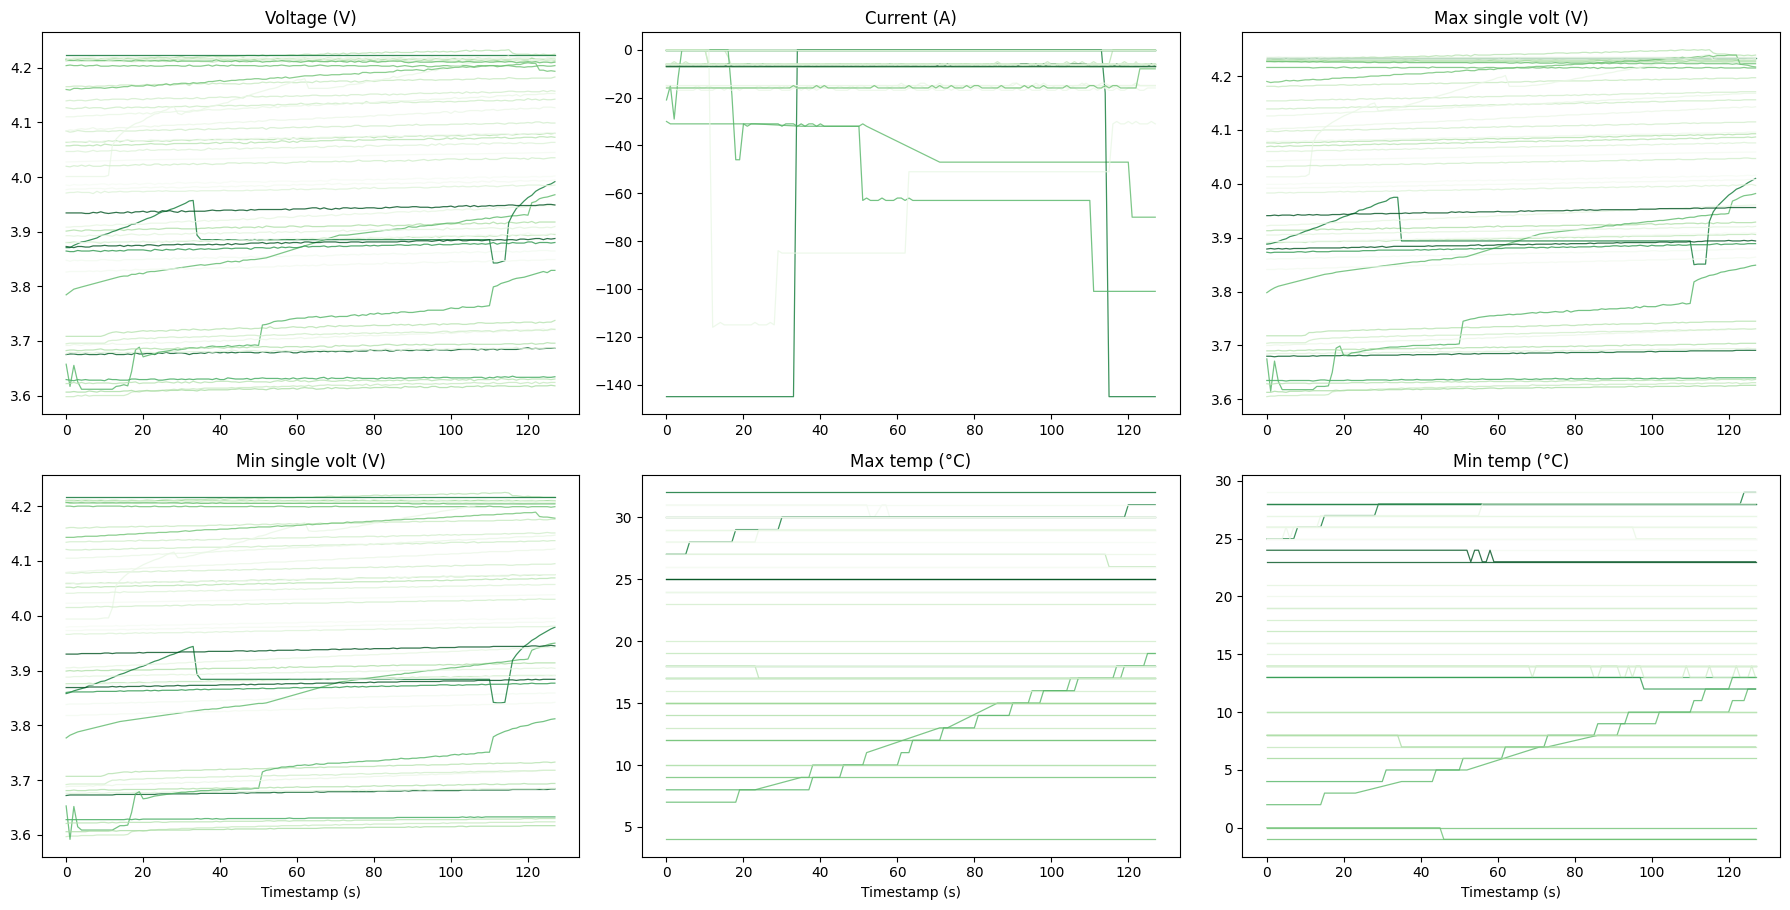

In [ ]:
# plot the values for a heatlhy car. Later snippets displayed darker.
plot_df = timeseries_df.merge(
    metadata_df[["snippet_index", "mileage"]], on="snippet_index", how="left"
)

mileage_norm = mcolors.Normalize(
    vmin=plot_df["mileage"].min(), vmax=plot_df["mileage"].max()
)

cmap = plt.get_cmap("Greens_r")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
ax_list = axes.flatten()

all_snippet_ids = plot_df["snippet_index"].unique()
snippet_ids = pd.Series(all_snippet_ids).sample(n=50, random_state=1)
for snippet_id in snippet_ids:
    snippet_df = plot_df[plot_df["snippet_index"] == snippet_id]

    color = cmap(mileage_norm(snippet_df["mileage"].iloc[0]))

    for i, (feature, ax) in enumerate(zip(PLOT_FEATURES, ax_list)):
        ax.plot(
            snippet_df["time_step"],
            snippet_df[feature],
            color=color,
            alpha=0.8,
            linewidth=0.9,
        )

for ax, title in zip(ax_list, PLOT_TITLES):
    ax.set_title(title)
    if ax in [axes[1, 0], axes[1, 1], axes[1, 2]]:
        ax.set_xlabel("Timestamp (s)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

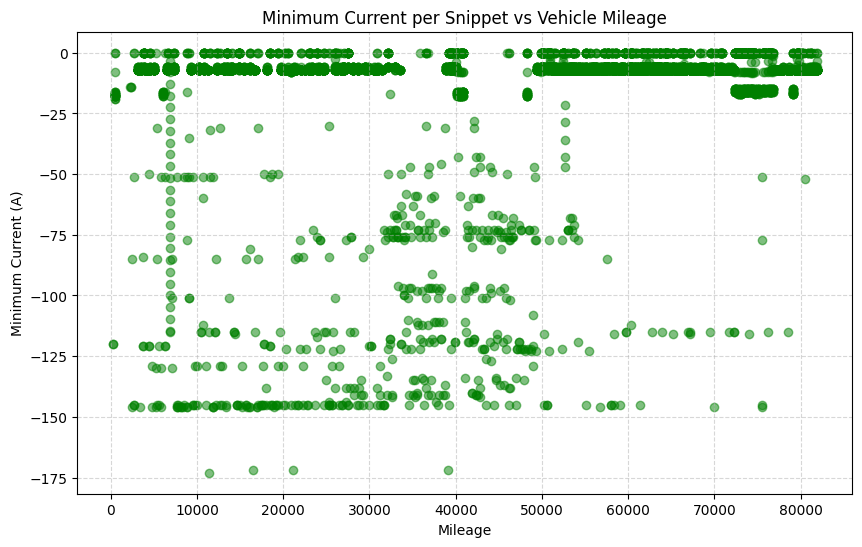

In [ ]:
# shows at which milgeages which current was used for the healthy car
snippet_min_current = plot_df.groupby("snippet_index")["current"].min()
snippet_min_current_df = snippet_min_current.reset_index()
snippet_min_current_df = snippet_min_current_df.rename(
    columns={"current": "min_current"}
)
plot_data = pd.merge(
    snippet_min_current_df,
    metadata_df[["snippet_index", "mileage"]],
    on="snippet_index",
    how="left",
)
plt.figure(figsize=(10, 6))

plt.scatter(plot_data["mileage"], plot_data["min_current"], alpha=0.5, color="green")

plt.title("Minimum Current per Snippet vs Vehicle Mileage")
plt.xlabel("Mileage")
plt.ylabel("Minimum Current (A)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
#fast charging usage statistics for healthy cars
healthy_car_ids = ind_ood_dict['ind_sorted']

car_charge_stats = []

for car_id in healthy_car_ids:

    fast_charge_count = 0
    slow_charge_count = 0

    snippet_files = all_car_dict.get(car_id, [])

    for file_path in snippet_files:
        snippet, metadata = torch.load(file_path, weights_only=False)

        current_column = snippet[:, CURRENT_COL_INDEX]

        min_current = np.min(current_column).item()

        if min_current < FAST_CHARGE_THRESHOLD:
            fast_charge_count += 1
        else:
            slow_charge_count += 1

    total_snippets = fast_charge_count + slow_charge_count
    car_charge_stats.append({
        'car_id': car_id,
        'fast_charge_snippets': fast_charge_count,
        'slow_charge_snippets': slow_charge_count,
        'total_snippets': total_snippets,
        'fast_charge_ratio': fast_charge_count / total_snippets
    })

stats_df = pd.DataFrame(car_charge_stats)

print('\nStats')
print(stats_df.head())

print('\nSummary')
print(stats_df.describe())

print(f'\nAverage fast charge ratio: {stats_df['fast_charge_ratio'].mean():.2f}')


Stats
   car_id  fast_charge_snippets  slow_charge_snippets  total_snippets  fast_charge_ratio
0     543                   143                    97             240           0.595833
1     512                    25                  9052            9077           0.002754
2     526                   185                    76             261           0.708812
3     536                   335                   192             527           0.635674
4     540                     0                  2023            2023           0.000000

Summary
           car_id  fast_charge_snippets  slow_charge_snippets  total_snippets  fast_charge_ratio
count   33.000000             33.000000             33.000000       33.000000          33.000000
mean   526.939394            166.878788           2174.818182     2341.696970           0.241092
std     13.946190            200.097751           2864.691480     2851.569814           0.293435
min    503.000000              0.000000             24.000000 

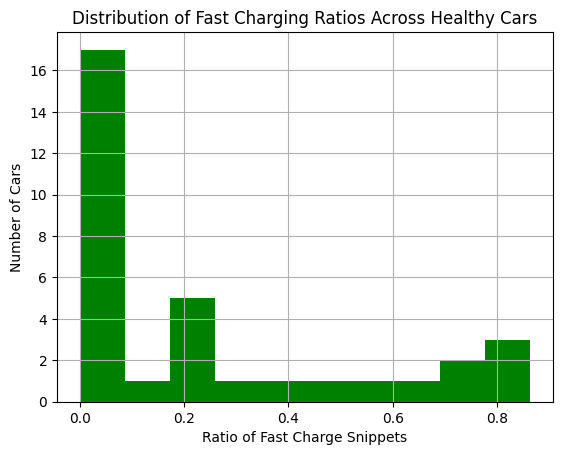

In [ ]:
# graph fast charge usage bins
stats_df["fast_charge_ratio"].hist(bins=10, color="green")
plt.title("Distribution of Fast Charging Ratios Across Healthy Cars")
plt.xlabel("Ratio of Fast Charge Snippets")
plt.ylabel("Number of Cars")
plt.show()

In [ ]:
# pick an unhealthy car for EDA
if not os.path.exists(EDA_METADATA_UNHEALTHY_FILE) or not os.path.exists(
    EDA_TIMESERIES_UNHEALTHY_FILE
):
    random_ind_id = random.choice(ind_ood_dict["ood_sorted"])
    rii_file_list = all_car_dict[random_ind_id]

    rii_files = []
    for each_file in rii_file_list:
        rii_files.append(torch.load(each_file, weights_only=False))

    rii_files = sorted(rii_files, key=lambda x: (x[1]["charge_segment"], x[0][0][7]))

    metadata_df_list = []
    timeseries_dfs_list = []

    for snippet_index, file in enumerate(rii_files):
        snippet, metadata = file

        metadata["snippet_index"] = snippet_index
        metadata_df_list.append(metadata)

        snippet_df = pd.DataFrame(snippet, columns=TIMESERIES_COLUMNS)
        snippet_df["snippet_index"] = snippet_index
        snippet_df["time_step"] = range(len(snippet_df))
        timeseries_dfs_list.append(snippet_df)

    metadata_df = pd.DataFrame(metadata_df_list)
    timeseries_df = pd.concat(timeseries_dfs_list, ignore_index=True)

    metadata_df.to_parquet(EDA_METADATA_UNHEALTHY_FILE)
    timeseries_df.to_parquet(EDA_TIMESERIES_UNHEALTHY_FILE)
else:
    metadata_df = pd.read_parquet(EDA_METADATA_UNHEALTHY_FILE)
    timeseries_df = pd.read_parquet(EDA_TIMESERIES_UNHEALTHY_FILE)

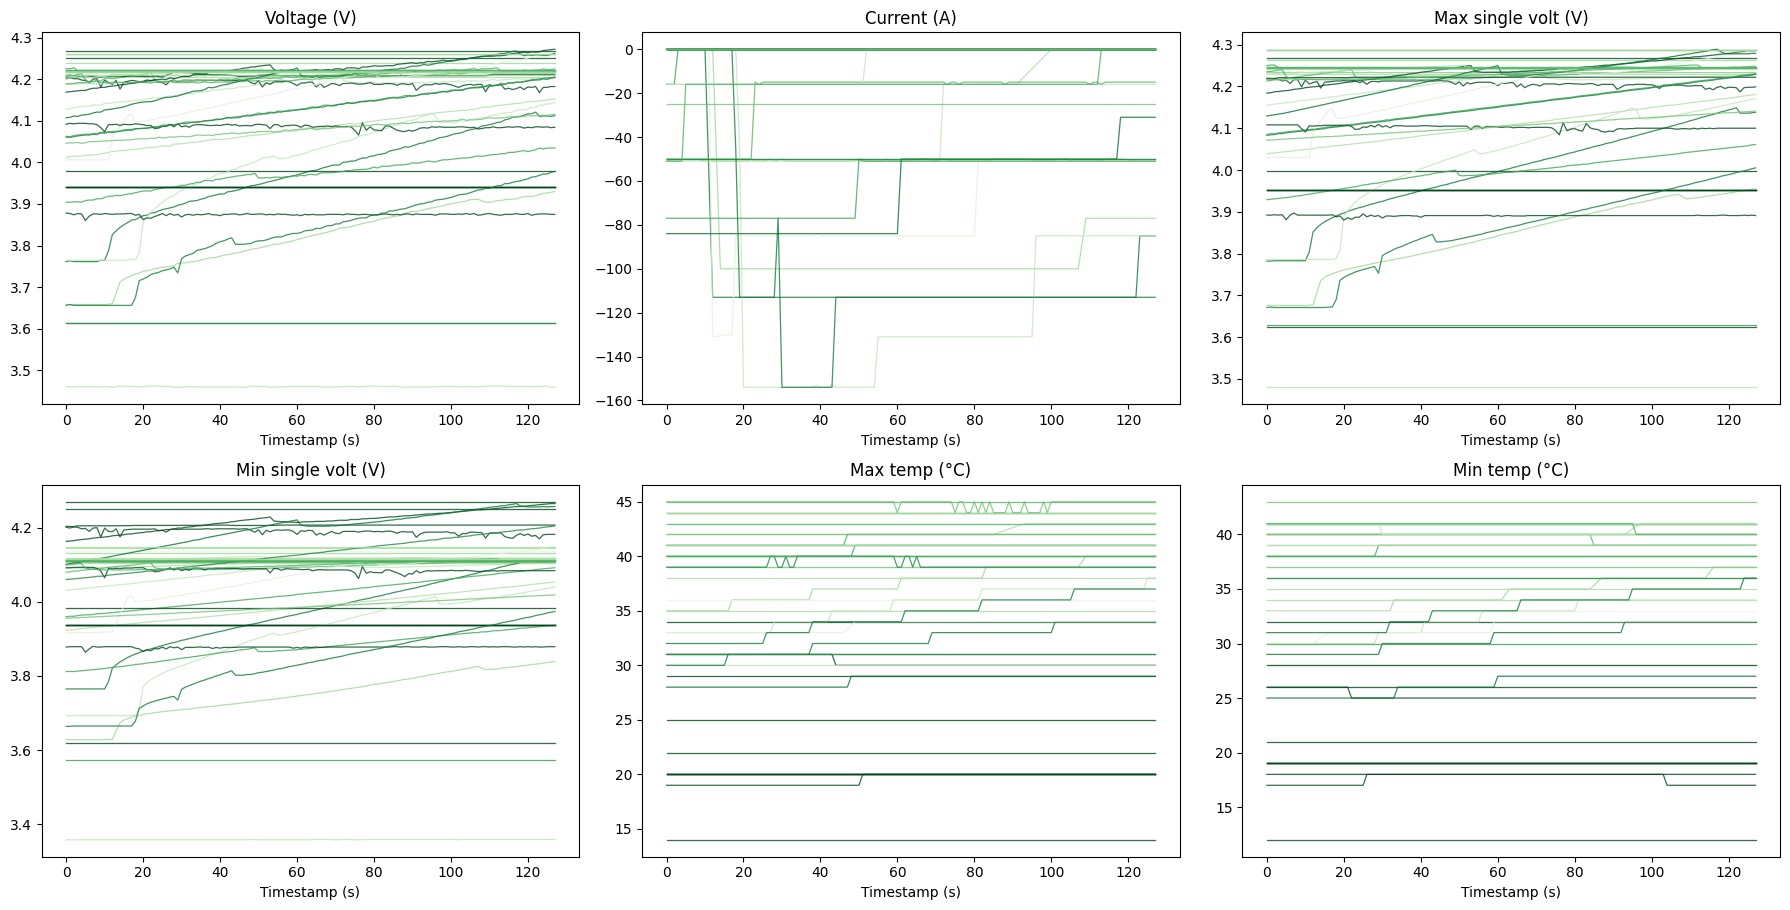

In [ ]:
# plot the values for an unheatlhy car. Later snippets displayed darker.
plot_df = timeseries_df.merge(
    metadata_df[["snippet_index", "mileage"]], on="snippet_index", how="left"
)
PLOT_FEATURES = [
    "volt",
    "current",
    "max_single_volt",
    "min_single_volt",
    "max_temp",
    "min_temp",
]
PLOT_TITLES = [
    "Voltage (V)",
    "Current (A)",
    "Max single volt (V)",
    "Min single volt (V)",
    "Max temp (°C)",
    "Min temp (°C)",
]

mileage_norm = mcolors.Normalize(
    vmin=plot_df["mileage"].min(), vmax=plot_df["mileage"].max()
)

cmap = plt.get_cmap("Greens_r")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
ax_list = axes.flatten()

all_snippet_ids = plot_df["snippet_index"].unique()
snippet_ids = pd.Series(all_snippet_ids).sample(n=50, random_state=1)
for snippet_id in snippet_ids:
    snippet_df = plot_df[plot_df["snippet_index"] == snippet_id]

    color = cmap(mileage_norm(snippet_df["mileage"].iloc[0]))

    for i, (feature, ax) in enumerate(zip(PLOT_FEATURES, ax_list)):
        ax.plot(
            snippet_df["time_step"],
            snippet_df[feature],
            color=color,
            alpha=0.8,
            linewidth=0.9,
        )

for ax, title in zip(ax_list, PLOT_TITLES):
    ax.set_title(title)
    ax.set_xlabel("Timestamp (s)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

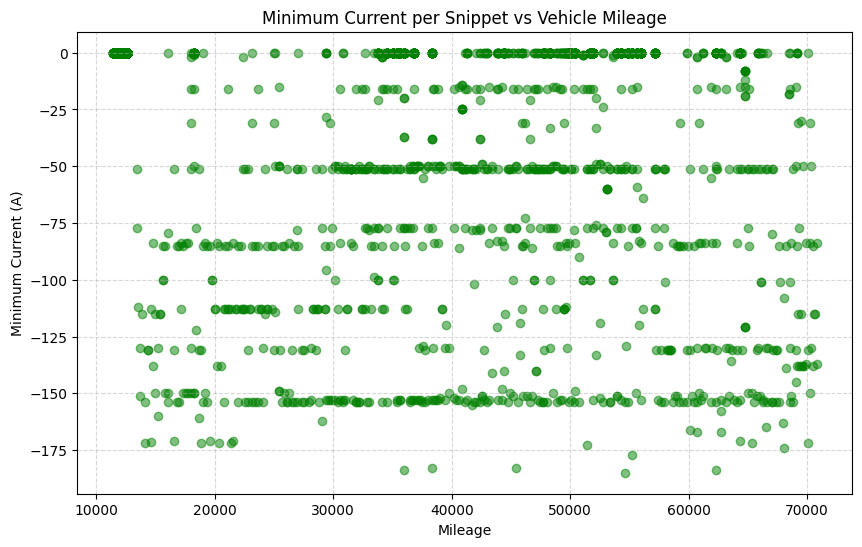

In [ ]:
# shows at which milgeages which current was used for the unhealthy car
snippet_min_current = plot_df.groupby("snippet_index")["current"].min()
snippet_min_current_df = snippet_min_current.reset_index()
snippet_min_current_df = snippet_min_current_df.rename(
    columns={"current": "min_current"}
)
plot_data = pd.merge(
    snippet_min_current_df,
    metadata_df[["snippet_index", "mileage"]],
    on="snippet_index",
    how="left",
)
plt.figure(figsize=(10, 6))

plt.scatter(plot_data["mileage"], plot_data["min_current"], alpha=0.5, color="green")

plt.title("Minimum Current per Snippet vs Vehicle Mileage")
plt.xlabel("Mileage")
plt.ylabel("Minimum Current (A)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
#fast charging usage statistics for unhealthy cars
unhealthy_car_ids = ind_ood_dict['ood_sorted']

car_charge_stats = []

for car_id in unhealthy_car_ids:

    fast_charge_count = 0
    slow_charge_count = 0

    snippet_files = all_car_dict.get(car_id, [])

    for file_path in snippet_files:
        snippet, metadata = torch.load(file_path, weights_only=False)

        current_column = snippet[:, CURRENT_COL_INDEX]

        min_current = np.min(current_column).item()

        if min_current < FAST_CHARGE_THRESHOLD:
            fast_charge_count += 1
        else:
            slow_charge_count += 1

    total_snippets = fast_charge_count + slow_charge_count
    car_charge_stats.append({
        'car_id': car_id,
        'fast_charge_snippets': fast_charge_count,
        'slow_charge_snippets': slow_charge_count,
        'total_snippets': total_snippets,
        'fast_charge_ratio': fast_charge_count / total_snippets
    })

stats_df = pd.DataFrame(car_charge_stats)

print('\nStats')
print(stats_df.head())

print('\nSummary')
print(stats_df.describe())

print(f'\nAverage fast charge ratio: {stats_df['fast_charge_ratio'].mean():.2f}')


Stats
   car_id  fast_charge_snippets  slow_charge_snippets  total_snippets  fast_charge_ratio
0     532                   683                  1590            2273           0.300484
1     515                   200                  2202            2402           0.083264
2     541                     1                  3078            3079           0.000325
3     504                   636                  1118            1754           0.362600
4     521                    54                 15295           15349           0.003518

Summary
          car_id  fast_charge_snippets  slow_charge_snippets  total_snippets  fast_charge_ratio
count   16.00000             16.000000             16.000000       16.000000          16.000000
mean   518.18750            515.500000           5675.187500     6190.687500           0.231204
std     13.98675            564.208118           6468.920118     6275.660897           0.262891
min    500.00000              1.000000            175.000000      

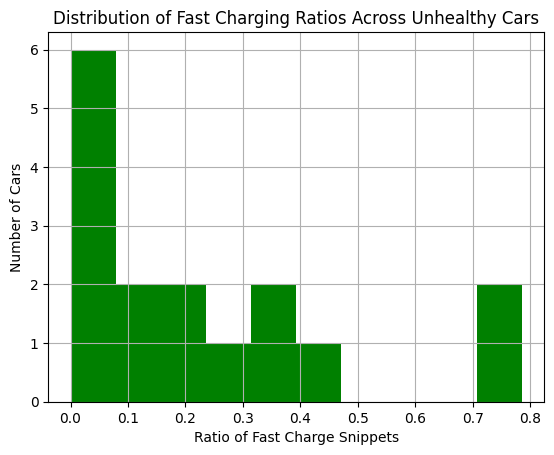

In [ ]:
# graph fast charge usage bins
stats_df["fast_charge_ratio"].hist(bins=10, color="green")
plt.title("Distribution of Fast Charging Ratios Across Unhealthy Cars")
plt.xlabel("Ratio of Fast Charge Snippets")
plt.ylabel("Number of Cars")
plt.show()

#Model

In [ ]:
# model and loss hyperparameters
EPOCHS = 75
LEARNING_RATE = 1e-3
NLL_WEIGHT = 1.0
LABEL_WEIGHT = 1.0

PATIENCE = 10
THRESHOLD = 0.001

ANNEAL_FUNCTION = "logistic"
K_VAL = 0.0025
X0_VAL = 2500
ANNEAL0 = 0.5


BATCH_SIZE = 64
NUM_WORKERS = 2
VARIABLE_LENGTH = True
FOLD_NUM = 0

CV_METRICS = {"train_time", "test_time", "max_ram_mb", "optimal_threshold"}

In [ ]:
# supporting functions. mostly same as original paper
def to_var(x):
    """Move tensor to GPU if possible"""
    if torch.cuda.is_available():
        x = x.cuda()
    return x


def to_tensor(input_embedding):
    """NumPy array -> PyTorch tensor"""
    return to_var(torch.from_numpy(np.array(input_embedding)))


def to_array(input_embedding):
    """PyTorch tensor -> NumPy array"""
    return input_embedding.cpu().numpy()


def pad_tensor(v, max_len):
    """Pad with zeros to max_len"""
    pad_size = max_len - v.shape[0]
    if pad_size <= 0:
        return v
    padding = torch.zeros(pad_size, v.shape[1], dtype=v.dtype)
    return torch.cat([v, padding], dim=0)


def collate(batch_data):
    """Collate a batch of time-series samples"""
    batch_data.sort(key=lambda xi: len(xi[0]), reverse=True)
    seq_lengths = [len(xi[0]) for xi in batch_data]
    max_len = max(seq_lengths)

    sent_seq = [torch.FloatTensor(v[0]) for v in batch_data]
    metadata_list = [xi[1] for xi in batch_data]
    metadata = OrderedDict(
        [
            ("label", []),
            ("car", []),
            ("charge_segment", []),
            ("mileage", []),
            ("timestamp", []),
        ]
    )
    for i in range(len(metadata_list)):
        for key, value in metadata_list[i].items():
            if key in metadata:
                metadata[key].append(value)

    padded_sent_seq = torch.stack([pad_tensor(v, max_len) for v in sent_seq], dim=0)
    metadata["seq_lengths"] = seq_lengths
    return padded_sent_seq, metadata


def kl_anneal_function(step: int) -> float:
    """KL divergence loss coefficient calculation"""
    if ANNEAL_FUNCTION == "logistic":
        return ANNEAL0 * float(1 / (1 + np.exp(-K_VAL * (step - X0_VAL))))
    elif ANNEAL_FUNCTION == "linear":
        return ANNEAL0 * min(1, step / X0_VAL)
    else:
        return ANNEAL0


def count_parameters(model):
    """Number of parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# loss function
def compute_losses(log_p, target, mean, log_v, mean_pred, batch, step):
    """Calculate KL, reconstruction, mileage losses"""
    nll_loss_fn = nn.SmoothL1Loss(reduction="mean")
    nll_loss = nll_loss_fn(log_p, target)

    kl_div = -0.5 * torch.sum(1 + log_v - mean.pow(2) - log_v.exp(), dim=1)
    kl_loss = torch.mean(kl_div)
    kl_weight = kl_anneal_function(step)

    label_loss = label_data_handler.loss(batch, mean_pred, is_mse=True)

    return nll_loss, kl_loss, label_loss, kl_weight

In [ ]:
# displaying loss curve to detec over/underfitting
def plot_loss_curve(train_losses, fold_num, model_name="Transformer"):
    """Plot loss curve to detect over/underfitting"""
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
    plt.title(f"{model_name} Training Loss - Fold {fold_num}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# same as original paper
class Dataset:
    """Create the dataset for a fold"""

    def __init__(
        self, all_car_dict_path, ind_ood_car_dict_path, train=True, fold_num=0
    ):
        ind_ood_car_dict = np.load(ind_ood_car_dict_path, allow_pickle=True).item()
        self.ind_car_num_list = ind_ood_car_dict["ind_sorted"]
        self.ood_car_num_list = ind_ood_car_dict["ood_sorted"]
        self.all_car_dict = np.load(all_car_dict_path, allow_pickle=True).item()

        if train:
            car_number = (
                self.ind_car_num_list[: int(fold_num * len(self.ind_car_num_list) / 5)]
                + self.ind_car_num_list[
                    int((fold_num + 1) * len(self.ind_car_num_list) / 5) :
                ]
            )
        else:
            car_number = (
                self.ind_car_num_list[
                    int(fold_num * len(self.ind_car_num_list) / 5) : int(
                        (fold_num + 1) * len(self.ind_car_num_list) / 5
                    )
                ]
                + self.ood_car_num_list
            )

        self.battery_dataset = []

        for each_num in car_number:
            for each_pkl in self.all_car_dict[each_num]:
                train1 = torch.load(each_pkl, weights_only=False)
                self.battery_dataset.append(train1)

    def __len__(self):
        return len(self.battery_dataset)

    def __getitem__(self, idx):
        file = self.battery_dataset[idx]
        return file

In [ ]:
# same as original paper
class Task:
    """Define VAE dimensions"""

    def __init__(
        self,
        columns,
        encoder_dimension=122,
        decoder_dimension=122,
        output_dimension=122,
        task_name="ev",
    ):
        self.encoder_dimension = encoder_dimension
        self.decoder_dimension = decoder_dimension
        self.output_dimension = output_dimension
        self.task_name = task_name
        self.columns = columns
        self.encoder = []
        self.decoder = []
        self.target = []
        eval(self.task_name.capitalize() + "Task.set_params")(self)
        eval(self.task_name.capitalize() + "Task.get_task_idx")(self, columns)

    def encoder_filter(self, input_embedding):
        return eval(self.task_name.capitalize() + "Task.task_encoder")(
            self, input_embedding, self.columns
        )

    def decoder_filter(self, input_embedding):
        self.decoder = self.encoder[: self.decoder_dimension]
        return to_tensor(to_array(input_embedding)[:, :, self.decoder])

    def target_filter(self, input_embedding):
        self.target = self.encoder[self.decoder_dimension :]
        return to_tensor(to_array(input_embedding)[:, :, self.target])

    def task_encoder(self, input_embedding, columns):
        return to_tensor(to_array(input_embedding)[:, :, self.encoder])


class EvTask(Task):
    """Specific dimensions for the anomaly detection taks"""

    def set_params(self):
        self.encoder_dimension = 6
        self.decoder_dimension = 2
        self.output_dimension = 4

    def get_task_idx(self, columns):
        self.encoder = np.array(
            [
                columns.index("soc"),
                columns.index("current"),
                columns.index("max_temp"),
                columns.index("max_single_volt"),
                columns.index("min_single_volt"),
                columns.index("volt"),
            ]
        ).astype(int)
        return self.encoder

In [ ]:
# same as original paper
class Normalizer:
    """Normalization based on a piece of a training set"""

    def __init__(self, dfs=None, variable_length=False):
        self.max_norm = 0
        self.min_norm = 0
        self.std = 0
        self.mean = 0
        res = []
        if dfs is not None:
            if variable_length:
                norm_length = min([len(df) for df in dfs])
                dfs = [df[0:norm_length] for df in dfs]
            res.extend(dfs)
            res = np.array(res)
            self.compute_min_max(res)
        else:
            raise Exception("df list not specified")

    def compute_min_max(self, res):
        column_max_all = np.max(res, axis=1)
        column_min_all = np.min(res, axis=1)
        column_std_all = np.std(res, axis=1)
        column_mean_all = np.mean(res, axis=1)
        self.max_norm = np.max(column_max_all, axis=0)
        self.min_norm = np.min(column_min_all, axis=0)
        self.std = np.mean(column_std_all, axis=0)
        self.mean = np.mean(column_mean_all, axis=0)

    def norm_func(self, df):
        df_norm = df.copy()
        df_norm = (df_norm - self.mean) / np.maximum(
            np.maximum(1e-4, self.std), 0.1 * (self.max_norm - self.min_norm)
        )
        return df_norm


class PreprocessNormalizer:
    """Applies normalization to the dataset"""

    def __init__(self, dataset, normalizer_fn=None):
        self.dataset = dataset
        self.normalizer_fn = normalizer_fn

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        df, metadata = self.dataset[idx][0], self.dataset[idx][1]
        if self.normalizer_fn is not None:
            df = self.normalizer_fn(df)
        return df, metadata

In [ ]:
class PositionalEncoding(nn.Module):
    """Standard positional encoding for the transformer"""

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe = pe.permute(1, 0, 2)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

In [ ]:
# same as original paper
class Label:
    """Manages mileage prediction"""

    def __init__(self, column_name, training_set, sample_length=50):
        self.label = column_name
        self.sample_length = sample_length

        num_samples = min(self.sample_length, len(training_set))

        self.sample_mileage = [
            training_set[i][1][self.label] for i in range(num_samples)
        ]
        self.max_mileage = max(self.sample_mileage)
        self.min_mileage = min(self.sample_mileage)

    def loss(self, batch, mean_pred, is_mse=True):
        label_data = []
        for i in batch[1][self.label]:
            norm_label = (i - self.min_mileage) / (self.max_mileage - self.min_mileage)
            label_data.append(norm_label)

        device = mean_pred.device

        label = torch.tensor(label_data, device=device).float()

        x = mean_pred.squeeze()
        y = label

        mse = torch.nn.MSELoss(reduction="mean")
        loss = 0
        if is_mse:
            loss = mse(x, y)
        return loss

In [ ]:
# needed for more robust training
class EarlyStopping:
    """Early stopping callback like in Keras"""

    def __init__(self, patience=5, min_delta=0, path="checkpoint.pt"):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)

In [ ]:
# initalize the dataset
data_pre = Dataset(
    train=True,
    fold_num=FOLD_NUM,
    all_car_dict_path=ALL_CAR_DICT_PATH + ".npy",
    ind_ood_car_dict_path=IND_OOD_CAR_DICT_PATH + ".npy",
)

print("Calculating normalization stats...")
normalizer = Normalizer(
    dfs=[data_pre[i][0] for i in range(min(200, len(data_pre)))],
    variable_length=VARIABLE_LENGTH,
)
print("Normalization stats calculated.")

train_dataset = PreprocessNormalizer(data_pre, normalizer_fn=normalizer.norm_func)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=False,
    pin_memory=torch.cuda.is_available(),
    collate_fn=collate if VARIABLE_LENGTH else None,
)

print(f"\nDataLoader initialized with {len(train_loader)} batches.")

Calculating normalization stats...
Normalization stats calculated.

DataLoader initialized with 871 batches.


In [ ]:
# initializing the mileage label
label_data_handler = Label(
    column_name="mileage", training_set=data_pre, sample_length=200
)

In [ ]:
# create the hyperparameters
data_task = EvTask(task_name="ev", columns=TIMESERIES_COLUMNS)

params = dict(
    hidden_size=64,
    latent_size=32,
    num_layers=1,
    nhead=8,
    dim_feedforward=128,
    variable_length=VARIABLE_LENGTH,
    encoder_embedding_size=data_task.encoder_dimension,
    decoder_embedding_size=data_task.decoder_dimension,
    output_embedding_size=data_task.output_dimension,
)

In [ ]:
class TransformerDyAD(nn.Module):
    """Transformer DyAD"""

    def __init__(
        self,
        hidden_size,
        latent_size,
        nhead,
        dim_feedforward,
        num_layers,
        variable_length,
        encoder_embedding_size,
        decoder_embedding_size,
        output_embedding_size,
        dropout=0.1,
        **params,
    ):
        super().__init__()
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.variable_length = variable_length

        self.encoder_input_proj = nn.Sequential(
            nn.Linear(encoder_embedding_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.decoder_input_proj = nn.Linear(decoder_embedding_size, hidden_size)

        self.pos_encoder = PositionalEncoding(hidden_size, dropout)

        self.hidden2mean = nn.Linear(hidden_size, latent_size)
        self.hidden2log_v = nn.Linear(hidden_size, latent_size)

        self.mean2latent = nn.Sequential(
            nn.Linear(latent_size, int(hidden_size / 2)),
            nn.ReLU(),
            nn.Linear(int(hidden_size / 2), 1),
        )
        self.latent2memory = nn.Linear(latent_size, hidden_size)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder_transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_size,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.decoder_transformer = nn.TransformerDecoder(
            decoder_layer, num_layers=num_layers
        )

        self.outputs2embedding = nn.Linear(hidden_size, output_embedding_size)

    def _create_padding_mask(self, seq_lengths, max_len):
        mask = torch.arange(max_len)[None, :] >= torch.tensor(seq_lengths)[:, None]
        return mask.to(torch.bool)

    def forward(
        self,
        input_sequence,
        encoder_filter,
        decoder_filter,
        seq_lengths,
        noise_scale=1.0,
    ):
        batch_size = input_sequence.size(0)
        max_len = input_sequence.size(1)
        device = input_sequence.device

        en_input_embedding = encoder_filter(input_sequence).to(torch.float32)
        en_input = self.encoder_input_proj(en_input_embedding)
        en_input = self.pos_encoder(en_input)

        src_key_padding_mask = None
        if self.variable_length:
            src_key_padding_mask = self._create_padding_mask(seq_lengths, max_len).to(
                device
            )

        transformer_out = self.encoder_transformer(
            en_input, src_key_padding_mask=src_key_padding_mask
        )

        if self.variable_length:
            mask_expanded = (~src_key_padding_mask).unsqueeze(-1).float()
            sum_hidden = (transformer_out * mask_expanded).sum(dim=1)
            count_hidden = mask_expanded.sum(dim=1).clamp(min=1e-9)
            hidden_state = sum_hidden / count_hidden
        else:
            hidden_state = transformer_out.mean(dim=1)

        mean = self.hidden2mean(hidden_state)
        log_v = self.hidden2log_v(hidden_state)
        mean_pred = self.mean2latent(mean)

        z = to_var(torch.randn([batch_size, self.latent_size]).to(device))
        if self.training:
            std = torch.exp(0.5 * log_v)
            z = z * std * noise_scale + mean
        else:
            z = mean

        de_input_embedding = decoder_filter(input_sequence).to(torch.float32)
        de_input = self.decoder_input_proj(de_input_embedding)
        de_input = self.pos_encoder(de_input)

        memory = self.latent2memory(z).unsqueeze(1)

        tgt_key_padding_mask = src_key_padding_mask

        memory = memory.repeat(1, max_len, 1)

        decoder_out = self.decoder_transformer(
            tgt=de_input,
            memory=memory,
            tgt_mask=None,
            tgt_key_padding_mask=tgt_key_padding_mask,
        )

        log_p = self.outputs2embedding(decoder_out)

        return log_p, mean, log_v, z, mean_pred

In [ ]:
# info about the model
model = to_var(TransformerDyAD(**params)).float()
print(model)

TransformerDyAD(
  (encoder_input_proj): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (decoder_input_proj): Linear(in_features=2, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (hidden2mean): Linear(in_features=64, out_features=32, bias=True)
  (hidden2log_v): Linear(in_features=64, out_features=32, bias=True)
  (mean2latent): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (latent2memory): Linear(in_features=32, out_features=64, bias=True)
  (encoder_transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1)

In [ ]:
# training and evaluating the folds
def run_fold_transformer(fold_num):
    """Transformer DyAD training"""
    print(f"\nStarting fold {fold_num}...")

    process = psutil.Process(os.getpid())
    max_memory_mb = 0

    data_pre = Dataset(
        train=True,
        fold_num=fold_num,
        all_car_dict_path=ALL_CAR_DICT_PATH + ".npy",
        ind_ood_car_dict_path=IND_OOD_CAR_DICT_PATH + ".npy",
    )

    normalizer = Normalizer(
        dfs=[data_pre[i][0] for i in range(min(200, len(data_pre)))],
        variable_length=VARIABLE_LENGTH,
    )

    train_dataset = PreprocessNormalizer(data_pre, normalizer_fn=normalizer.norm_func)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        collate_fn=collate if VARIABLE_LENGTH else None,
    )

    global label_data_handler
    label_data_handler = Label(
        column_name="mileage", training_set=data_pre, sample_length=200
    )

    model = to_var(TransformerDyAD(**params)).float()

    print(f"Transformer Trainable Parameters: {count_parameters(model):,}")

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=0.3,
    )

    temp_checkpoint_path = os.path.join(
        NEURAL_FILEPATH, f"temp_best_fold_{fold_num}.pt"
    )
    early_stopping = EarlyStopping(
        patience=3, min_delta=0.001, path=temp_checkpoint_path
    )

    train_start_time = time.time()
    step = 0
    epoch_losses = []

    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0

        for batch_data, batch_meta in train_loader:
            batch_data = to_var(batch_data).float()
            seq_lengths = batch_meta["seq_lengths"]

            log_p, mean, log_v, z, mean_pred = model(
                batch_data,
                data_task.encoder_filter,
                data_task.decoder_filter,
                seq_lengths,
            )
            target = data_task.target_filter(batch_data)

            nll_loss, kl_loss, label_loss, kl_weight = compute_losses(
                log_p, target, mean, log_v, mean_pred, (batch_data, batch_meta), step
            )

            loss = (
                (NLL_WEIGHT * nll_loss)
                + (LABEL_WEIGHT * label_loss)
                + (kl_weight * kl_loss)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            step += 1
            running_loss += loss.item()

        avg_epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)

        current_mem = process.memory_info().rss / (1024 * 1024)
        max_memory_mb = max(max_memory_mb, current_mem)

        print(
            f"Epoch {epoch}/{EPOCHS} - Loss: {avg_epoch_loss:.6f} - RAM: {current_mem:.0f}MB"
        )

        early_stopping(avg_epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    train_end_time = time.time()
    train_duration = train_end_time - train_start_time

    print(f"Loading best weights from {temp_checkpoint_path}")
    model.load_state_dict(torch.load(temp_checkpoint_path, weights_only=True))

    fold_model_path = os.path.join(
        NEURAL_FILEPATH, f"transformer_dyad_fold_{fold_num}.torch"
    )
    torch.save(model, fold_model_path)
    print(f"Best model saved to {fold_model_path}")

    fold_normalizer_path = os.path.join(
        NEURAL_FILEPATH, f"normalizer_fold_{fold_num}.pkl"
    )
    with open(fold_normalizer_path, "wb") as f:
        pickle.dump(normalizer, f)

    if os.path.exists(temp_checkpoint_path):
        os.remove(temp_checkpoint_path)
        print("Temporary checkpoint deleted.")

    plot_loss_curve(epoch_losses, fold_num, model_name="Transformer DyAD")

    test_data_pre = Dataset(
        train=False,
        fold_num=fold_num,
        all_car_dict_path=ALL_CAR_DICT_PATH + ".npy",
        ind_ood_car_dict_path=IND_OOD_CAR_DICT_PATH + ".npy",
    )

    test_dataset = PreprocessNormalizer(
        test_data_pre, normalizer_fn=normalizer.norm_func
    )
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate if VARIABLE_LENGTH else None,
    )

    test_start_time = time.time()
    model.eval()
    snippet_results = []
    recon_loss_fn = nn.SmoothL1Loss(reduction="none")

    with torch.no_grad():
        for batch_data, batch_meta in test_loader:
            batch_data = to_var(batch_data).float()
            seq_lengths = batch_meta["seq_lengths"]

            log_p, _, _, _, _ = model(
                batch_data,
                data_task.encoder_filter,
                data_task.decoder_filter,
                seq_lengths,
            )
            target = data_task.target_filter(batch_data)

            loss_per_element = recon_loss_fn(log_p, target)
            rec_error_per_snippet = torch.mean(loss_per_element, dim=[1, 2])

            for i in range(len(batch_meta["car"])):
                snippet_results.append(
                    {
                        "car": batch_meta["car"][i],
                        "label": 0 if batch_meta["label"][i] == "00" else 1,
                        "rec_error": rec_error_per_snippet[i].item(),
                    }
                )

    test_end_time = time.time()
    test_duration = test_end_time - test_start_time

    snippet_df = pd.DataFrame(snippet_results)
    vehicle_scores = snippet_df.groupby("car").agg(
        vehicle_label=("label", "max"),
        vehicle_score=(
            "rec_error",
            lambda errors: errors.nlargest(max(1, int(len(errors) * 0.10))).mean(),
        ),
    )

    y_true = vehicle_scores["vehicle_label"]
    y_score = vehicle_scores["vehicle_score"]

    auroc = roc_auc_score(y_true, y_score)
    auprc = average_precision_score(y_true, y_score)

    precision_curve, recall_curve, thresholds = precision_recall_curve(y_true, y_score)
    f1_scores = (2 * precision_curve * recall_curve) / (
        precision_curve + recall_curve + 1e-10
    )
    best_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[best_f1_idx]

    metrics = {
        "auroc": auroc,
        "auprc": auprc,
        "f1": f1_scores[best_f1_idx],
        "precision": precision_curve[best_f1_idx],
        "recall": recall_curve[best_f1_idx],
        "optimal_threshold": optimal_threshold,
        "train_time": train_duration,
        "test_time": test_duration,
        "max_ram_mb": max_memory_mb,
    }

    print(
        f'Fold {fold_num} Metrics: AUROC={metrics["auroc"]:.4f}, F1={metrics["f1"]:.4f}, RAM={metrics["max_ram_mb"]:.0f}MB'
    )
    return metrics


Starting fold 0...
Transformer Trainable Parameters: 96,133
Epoch 1/75 - Loss: 926.197747 - RAM: 2645MB
Epoch 2/75 - Loss: 635.610402 - RAM: 2645MB
Epoch 3/75 - Loss: 605.528585 - RAM: 2645MB
Epoch 4/75 - Loss: 588.067683 - RAM: 2645MB
Epoch 5/75 - Loss: 540.071518 - RAM: 2645MB
Epoch 6/75 - Loss: 490.500698 - RAM: 2645MB
Epoch 7/75 - Loss: 465.439014 - RAM: 2645MB
Epoch 8/75 - Loss: 443.288435 - RAM: 2645MB
Epoch 9/75 - Loss: 417.595231 - RAM: 2645MB
Epoch 10/75 - Loss: 398.421232 - RAM: 2645MB
Epoch 11/75 - Loss: 436.886664 - RAM: 2645MB
Epoch 12/75 - Loss: 413.531747 - RAM: 2645MB
Epoch 13/75 - Loss: 461.588617 - RAM: 2645MB
Early stopping triggered
Loading best weights from /content/drive/My Drive/Projects/EV Batteries/temp_best_fold_0.pt
Best model saved to /content/drive/My Drive/Projects/EV Batteries/transformer_dyad_fold_0.torch
Temporary checkpoint deleted.


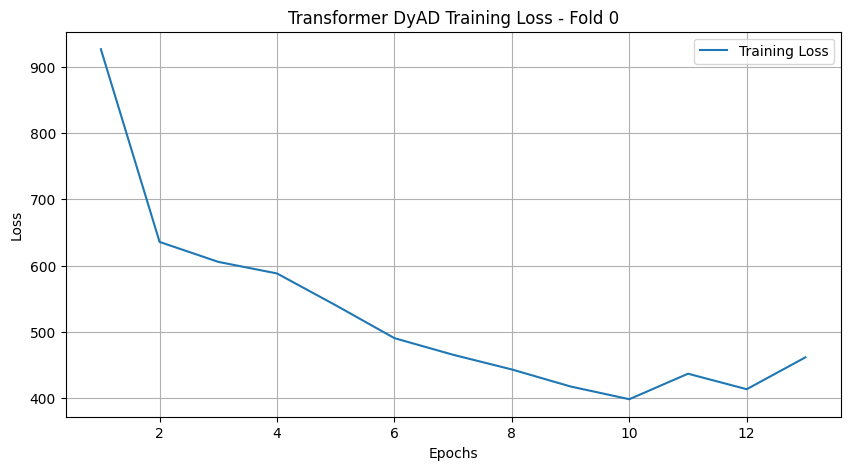

Fold 0 Metrics: AUROC=0.8542, F1=0.9091, RAM=2645MB

Starting fold 1...
Transformer Trainable Parameters: 96,133
Epoch 1/75 - Loss: 4.806083 - RAM: 3699MB
Epoch 2/75 - Loss: 3.472612 - RAM: 3699MB
Epoch 3/75 - Loss: 3.325051 - RAM: 3699MB
Epoch 4/75 - Loss: 2.977075 - RAM: 3699MB
Epoch 5/75 - Loss: 2.728100 - RAM: 3699MB
Epoch 6/75 - Loss: 2.606498 - RAM: 3699MB
Epoch 7/75 - Loss: 2.524101 - RAM: 3699MB
Epoch 8/75 - Loss: 2.476349 - RAM: 3699MB
Epoch 9/75 - Loss: 2.426101 - RAM: 3699MB
Epoch 10/75 - Loss: 2.384226 - RAM: 3699MB
Epoch 11/75 - Loss: 2.337721 - RAM: 3699MB
Epoch 12/75 - Loss: 2.254526 - RAM: 3699MB
Epoch 13/75 - Loss: 2.155817 - RAM: 3699MB
Epoch 14/75 - Loss: 2.087108 - RAM: 3699MB
Epoch 15/75 - Loss: 1.989388 - RAM: 3699MB
Epoch 16/75 - Loss: 1.941742 - RAM: 3699MB
Epoch 17/75 - Loss: 1.905680 - RAM: 3699MB
Epoch 18/75 - Loss: 1.867818 - RAM: 3699MB
Epoch 19/75 - Loss: 1.846994 - RAM: 3699MB
Epoch 20/75 - Loss: 1.802142 - RAM: 3699MB
Epoch 21/75 - Loss: 1.780301 - RAM: 

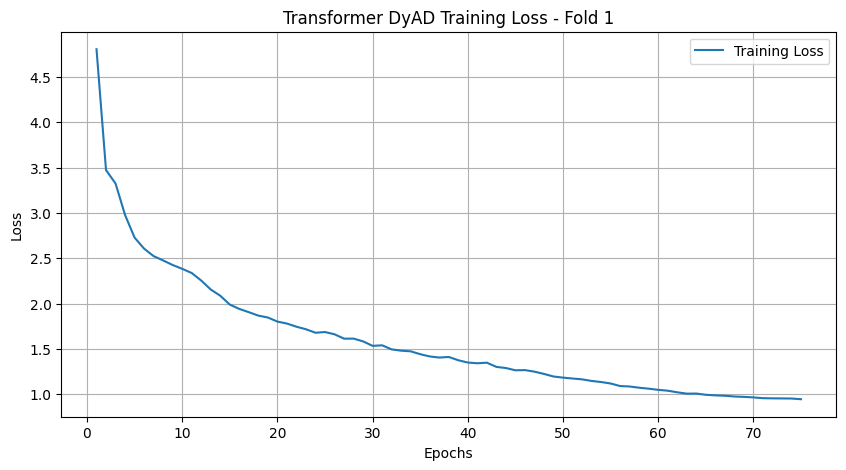

Fold 1 Metrics: AUROC=0.8125, F1=0.9091, RAM=3699MB

Starting fold 2...
Transformer Trainable Parameters: 96,133
Epoch 1/75 - Loss: 8.864301 - RAM: 3762MB
Epoch 2/75 - Loss: 7.539902 - RAM: 3762MB
Epoch 3/75 - Loss: 7.409816 - RAM: 3762MB
Epoch 4/75 - Loss: 6.634059 - RAM: 3762MB
Epoch 5/75 - Loss: 6.056511 - RAM: 3762MB
Epoch 6/75 - Loss: 5.814732 - RAM: 3762MB
Epoch 7/75 - Loss: 5.569998 - RAM: 3762MB
Epoch 8/75 - Loss: 5.309047 - RAM: 3762MB
Epoch 9/75 - Loss: 4.971296 - RAM: 3762MB
Epoch 10/75 - Loss: 5.261705 - RAM: 3762MB
Epoch 11/75 - Loss: 4.975157 - RAM: 3762MB
Epoch 12/75 - Loss: 5.828526 - RAM: 3762MB
Early stopping triggered
Loading best weights from /content/drive/My Drive/Projects/EV Batteries/temp_best_fold_2.pt
Best model saved to /content/drive/My Drive/Projects/EV Batteries/transformer_dyad_fold_2.torch
Temporary checkpoint deleted.


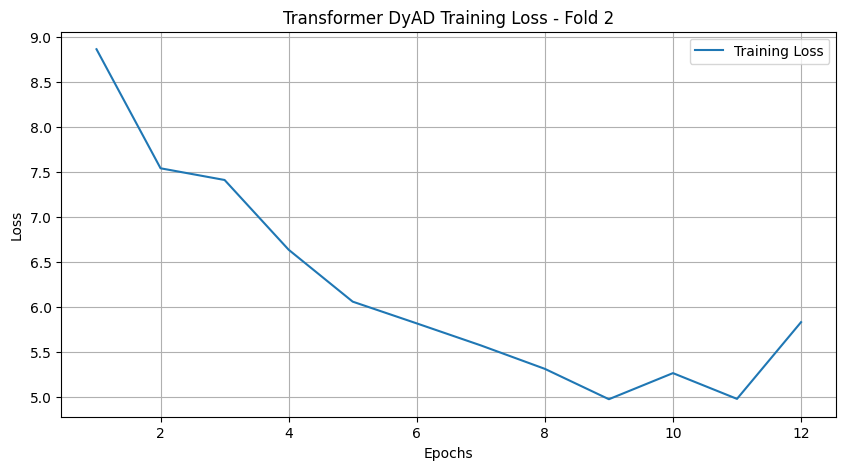

Fold 2 Metrics: AUROC=0.7083, F1=0.8889, RAM=3762MB

Starting fold 3...
Transformer Trainable Parameters: 96,133
Epoch 1/75 - Loss: 8.246703 - RAM: 3830MB
Epoch 2/75 - Loss: 6.916365 - RAM: 3830MB
Epoch 3/75 - Loss: 6.564363 - RAM: 3830MB
Epoch 4/75 - Loss: 5.810689 - RAM: 3830MB
Epoch 5/75 - Loss: 5.556629 - RAM: 3830MB
Epoch 6/75 - Loss: 5.406049 - RAM: 3830MB
Epoch 7/75 - Loss: 5.242214 - RAM: 3830MB
Epoch 8/75 - Loss: 5.127324 - RAM: 3830MB
Epoch 9/75 - Loss: 4.919250 - RAM: 3830MB
Epoch 10/75 - Loss: 4.732815 - RAM: 3830MB
Epoch 11/75 - Loss: 4.853937 - RAM: 3830MB
Epoch 12/75 - Loss: 4.686869 - RAM: 3830MB
Epoch 13/75 - Loss: 4.910448 - RAM: 3830MB
Epoch 14/75 - Loss: 4.948668 - RAM: 3830MB
Epoch 15/75 - Loss: 4.288878 - RAM: 3830MB
Epoch 16/75 - Loss: 4.153458 - RAM: 3830MB
Epoch 17/75 - Loss: 4.689413 - RAM: 3830MB
Epoch 18/75 - Loss: 4.967588 - RAM: 3830MB
Epoch 19/75 - Loss: 4.410672 - RAM: 3830MB
Early stopping triggered
Loading best weights from /content/drive/My Drive/Proj

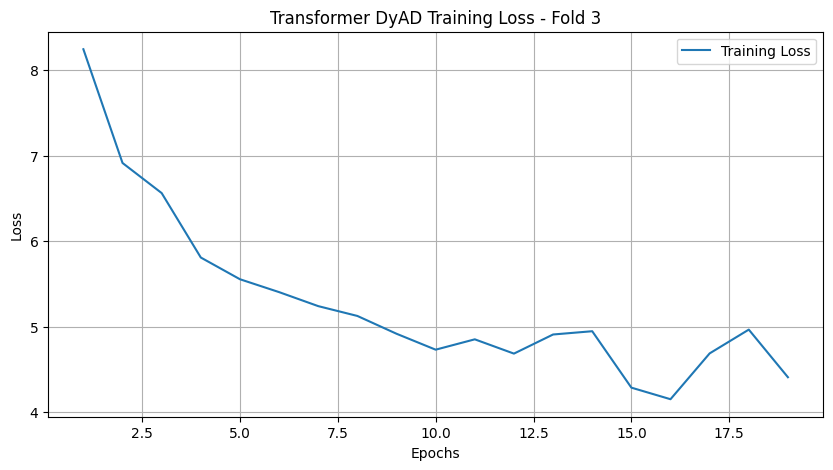

Fold 3 Metrics: AUROC=0.9196, F1=0.9143, RAM=3830MB

Starting fold 4...
Transformer Trainable Parameters: 96,133
Epoch 1/75 - Loss: 8.111910 - RAM: 3816MB
Epoch 2/75 - Loss: 6.906577 - RAM: 3816MB
Epoch 3/75 - Loss: 6.692512 - RAM: 3816MB
Epoch 4/75 - Loss: 6.011839 - RAM: 3816MB
Epoch 5/75 - Loss: 5.696465 - RAM: 3816MB
Epoch 6/75 - Loss: 5.529524 - RAM: 3816MB
Epoch 7/75 - Loss: 5.393585 - RAM: 3816MB
Epoch 8/75 - Loss: 5.092415 - RAM: 3816MB
Epoch 9/75 - Loss: 4.726150 - RAM: 3816MB
Epoch 10/75 - Loss: 4.841291 - RAM: 3816MB
Epoch 11/75 - Loss: 4.865320 - RAM: 3816MB
Epoch 12/75 - Loss: 4.350488 - RAM: 3816MB
Epoch 13/75 - Loss: 4.929571 - RAM: 3816MB
Epoch 14/75 - Loss: 5.428864 - RAM: 3816MB
Epoch 15/75 - Loss: 4.664695 - RAM: 3816MB
Early stopping triggered
Loading best weights from /content/drive/My Drive/Projects/EV Batteries/temp_best_fold_4.pt
Best model saved to /content/drive/My Drive/Projects/EV Batteries/transformer_dyad_fold_4.torch
Temporary checkpoint deleted.


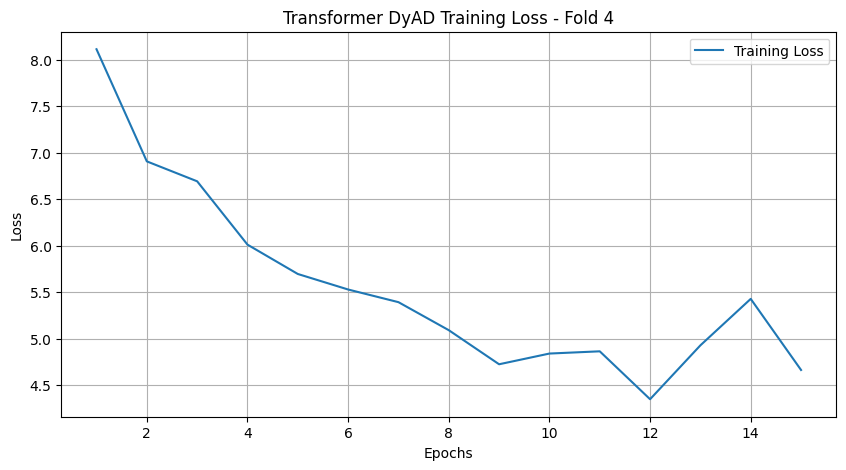

Fold 4 Metrics: AUROC=0.8304, F1=0.8649, RAM=3816MB


In [ ]:
#running the training and displaying the results
random.seed(777)
fold_results = []

for i in range(5):
    metrics = run_fold_transformer(fold_num=i)
    fold_results.append(metrics)

In [ ]:
print('FINAL RESULTS (5-Fold)')

metric_keys = fold_results[0].keys()
final_stats = {}

for key in metric_keys:
    values = [res[key] for res in fold_results]
    mean_val = np.mean(values)
    std_val = np.std(values)
    cv_val = (std_val / mean_val) if mean_val != 0 else 0.0
    final_stats[key] = (mean_val, std_val, cv_val)

    print(f'Metric: {key.upper()}')
    print(f'  Values: {[f'{v:.4f}' for v in values]}')
    print(f'  Result: {mean_val:.4f} \u00b1 {std_val:.4f}')
    if key in CV_METRICS:
        cv_val = (std_val / mean_val) if mean_val != 0 else 0.0
        print(f'  CV:     {cv_val:.2%}')

FINAL RESULTS (5-Fold)
Metric: AUROC
  Values: ['0.8542', '0.8125', '0.7083', '0.9196', '0.8304']
  Result: 0.8250 ± 0.0687
Metric: AUPRC
  Values: ['0.9390', '0.8947', '0.8639', '0.9657', '0.9310']
  Result: 0.9189 ± 0.0356
Metric: F1
  Values: ['0.9091', '0.9091', '0.8889', '0.9143', '0.8649']
  Result: 0.8972 ± 0.0184
Metric: PRECISION
  Values: ['0.8824', '0.8824', '0.8000', '0.8421', '0.7619']
  Result: 0.8337 ± 0.0471
Metric: RECALL
  Values: ['0.9375', '0.9375', '1.0000', '1.0000', '1.0000']
  Result: 0.9750 ± 0.0306
Metric: OPTIMAL_THRESHOLD
  Values: ['1.6239', '1.1660', '0.6943', '0.8342', '0.8673']
  Result: 1.0371 ± 0.3312
  CV:     31.93%
Metric: TRAIN_TIME
  Values: ['153.8701', '966.5209', '149.9339', '291.5947', '215.8151']
  Result: 355.5470 ± 309.7916
  CV:     87.13%
Metric: TEST_TIME
  Values: ['14.9632', '14.4205', '14.7756', '13.0144', '13.6380']
  Result: 14.1624 ± 0.7317
  CV:     5.17%
Metric: MAX_RAM_MB
  Values: ['2645.2695', '3698.7539', '3761.8398', '3829.5

In [ ]:
class DynamicVAE(nn.Module):
    """Original VAE"""

    def __init__(
        self,
        rnn_type,
        hidden_size,
        latent_size,
        encoder_embedding_size,
        output_embedding_size,
        decoder_embedding_size,
        num_layers=1,
        bidirectional=False,
        variable_length=False,
        **params,
    ):
        super().__init__()
        self.latent_size = latent_size
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.variable_length = variable_length

        rnn = getattr(nn, rnn_type.upper())

        self.encoder_rnn = rnn(
            encoder_embedding_size,
            hidden_size,
            num_layers=num_layers,
            bidirectional=self.bidirectional,
            batch_first=True,
        )
        self.decoder_rnn = rnn(
            decoder_embedding_size,
            hidden_size,
            num_layers=num_layers,
            bidirectional=self.bidirectional,
            batch_first=True,
        )

        self.hidden_factor = (2 if bidirectional else 1) * num_layers

        self.hidden2mean = nn.Linear(hidden_size * self.hidden_factor, latent_size)
        self.hidden2log_v = nn.Linear(hidden_size * self.hidden_factor, latent_size)
        self.latent2hidden = nn.Linear(latent_size, hidden_size * self.hidden_factor)
        self.outputs2embedding = nn.Linear(
            hidden_size * (2 if bidirectional else 1), output_embedding_size
        )
        self.mean2latent = nn.Sequential(
            nn.Linear(latent_size, int(hidden_size / 2)),
            nn.ReLU(),
            nn.Linear(int(hidden_size / 2), 1),
        )

    def forward(
        self,
        input_sequence,
        encoder_filter,
        decoder_filter,
        seq_lengths,
        noise_scale=1.0,
    ):
        batch_size = input_sequence.size(0)

        en_input_sequence = encoder_filter(input_sequence)
        en_input_embedding = en_input_sequence.to(torch.float32)

        if self.variable_length:
            en_input_embedding = pack_padded_sequence(
                en_input_embedding, seq_lengths, batch_first=True
            )

        output, hidden = self.encoder_rnn(en_input_embedding)

        if self.bidirectional or self.num_layers > 1:
            hidden = hidden.view(batch_size, self.hidden_size * self.hidden_factor)
        else:
            hidden = hidden.squeeze()

        mean = self.hidden2mean(hidden)
        log_v = self.hidden2log_v(hidden)
        std = torch.exp(0.5 * log_v)
        mean_pred = self.mean2latent(mean)

        z = to_var(torch.randn([batch_size, self.latent_size]))
        if self.training:
            z = z * std * noise_scale + mean
        else:
            z = mean

        hidden = self.latent2hidden(z)

        if self.bidirectional or self.num_layers > 1:
            hidden = hidden.view(self.hidden_factor, batch_size, self.hidden_size)
        else:
            hidden = hidden.unsqueeze(0)

        de_input_sequence = decoder_filter(input_sequence)
        de_input_embedding = de_input_sequence.to(torch.float32)

        if self.variable_length:
            de_input_embedding = pack_padded_sequence(
                de_input_embedding, seq_lengths, batch_first=True
            )
            outputs, _ = self.decoder_rnn(de_input_embedding, hidden)
            outputs, _ = pad_packed_sequence(outputs, batch_first=True)
        else:
            outputs, _ = self.decoder_rnn(de_input_embedding, hidden)

        log_p = self.outputs2embedding(outputs)

        return log_p, mean, log_v, z, mean_pred

In [ ]:
# create the hyperparameters
gru_params = dict(
    rnn_type="gru",
    hidden_size=64,
    latent_size=32,
    num_layers=1,
    bidirectional=False,
    variable_length=VARIABLE_LENGTH,
    encoder_embedding_size=data_task.encoder_dimension,
    decoder_embedding_size=data_task.decoder_dimension,
    output_embedding_size=data_task.output_dimension,
)

In [ ]:
# info about the model
model = to_var(DynamicVAE(**gru_params)).float()
print(model)

DynamicVAE(
  (encoder_rnn): GRU(6, 64, batch_first=True)
  (decoder_rnn): GRU(2, 64, batch_first=True)
  (hidden2mean): Linear(in_features=64, out_features=32, bias=True)
  (hidden2log_v): Linear(in_features=64, out_features=32, bias=True)
  (latent2hidden): Linear(in_features=32, out_features=64, bias=True)
  (outputs2embedding): Linear(in_features=64, out_features=4, bias=True)
  (mean2latent): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
# training and evaluating the folds
def run_fold_gru(fold_num, inference_loss_type="huber"):
    """Original DyAD training"""
    print(f"\nStarting GRU fold {fold_num}...")

    process = psutil.Process(os.getpid())
    max_memory_mb = 0

    data_pre = Dataset(
        train=True,
        fold_num=fold_num,
        all_car_dict_path=ALL_CAR_DICT_PATH + ".npy",
        ind_ood_car_dict_path=IND_OOD_CAR_DICT_PATH + ".npy",
    )

    transformer_normalizer_path = os.path.join(
        NEURAL_FILEPATH, f"normalizer_fold_{fold_num}.pkl"
    )

    if os.path.exists(transformer_normalizer_path):
        print(f"Loading normalizer from: {transformer_normalizer_path}")
        with open(transformer_normalizer_path, "rb") as f:
            normalizer = pickle.load(f)
    else:
        print("Transformer normalizer not found. Calculating new statistics...")
        normalizer = Normalizer(
            dfs=[data_pre[i][0] for i in range(min(200, len(data_pre)))],
            variable_length=VARIABLE_LENGTH,
        )

    train_dataset = PreprocessNormalizer(data_pre, normalizer_fn=normalizer.norm_func)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        collate_fn=collate if VARIABLE_LENGTH else None,
    )

    global label_data_handler
    label_data_handler = Label(
        column_name="mileage", training_set=data_pre, sample_length=200
    )

    model = to_var(DynamicVAE(**gru_params)).float()

    print(f"GRU Trainable Parameters: {count_parameters(model):,}")

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    temp_checkpoint_path = os.path.join(
        NEURAL_FILEPATH, f"temp_gru_best_fold_{fold_num}.pt"
    )
    early_stopping = EarlyStopping(
        patience=3, min_delta=0.001, path=temp_checkpoint_path
    )

    train_start_time = time.time()
    step = 0
    epoch_losses = []

    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0

        for batch_data, batch_meta in train_loader:
            batch_data = to_var(batch_data).float()
            seq_lengths = batch_meta["seq_lengths"]

            log_p, mean, log_v, z, mean_pred = model(
                batch_data,
                data_task.encoder_filter,
                data_task.decoder_filter,
                seq_lengths,
            )
            target = data_task.target_filter(batch_data)

            nll_loss, kl_loss, label_loss, kl_weight = compute_losses(
                log_p, target, mean, log_v, mean_pred, (batch_data, batch_meta), step
            )

            loss = (
                (NLL_WEIGHT * nll_loss)
                + (LABEL_WEIGHT * label_loss)
                + (kl_weight * kl_loss)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            step += 1
            running_loss += loss.item()

        avg_epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)

        current_mem = process.memory_info().rss / (1024 * 1024)
        max_memory_mb = max(max_memory_mb, current_mem)

        print(
            f"Epoch {epoch}/{EPOCHS} - Loss: {avg_epoch_loss:.6f} - RAM: {current_mem:.0f}MB"
        )

        early_stopping(avg_epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    train_end_time = time.time()
    train_duration = train_end_time - train_start_time

    print(f"Loading best weights from {temp_checkpoint_path}")
    model.load_state_dict(torch.load(temp_checkpoint_path, weights_only=True))

    fold_model_path = os.path.join(NEURAL_FILEPATH, f"gru_dyad_fold_{fold_num}.torch")
    torch.save(model, fold_model_path)
    print(f"Best GRU model saved to {fold_model_path}")

    fold_normalizer_path = os.path.join(
        NEURAL_FILEPATH, f"gru_normalizer_fold_{fold_num}.pkl"
    )
    with open(fold_normalizer_path, "wb") as f:
        pickle.dump(normalizer, f)

    if os.path.exists(temp_checkpoint_path):
        os.remove(temp_checkpoint_path)
        print("Temporary checkpoint deleted.")

    plot_loss_curve(epoch_losses, fold_num, model_name="GRU DyAD")

    test_data_pre = Dataset(
        train=False,
        fold_num=fold_num,
        all_car_dict_path=ALL_CAR_DICT_PATH + ".npy",
        ind_ood_car_dict_path=IND_OOD_CAR_DICT_PATH + ".npy",
    )

    test_dataset = PreprocessNormalizer(
        test_data_pre, normalizer_fn=normalizer.norm_func
    )
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate if VARIABLE_LENGTH else None,
    )

    test_start_time = time.time()
    model.eval()
    snippet_results = []

    if inference_loss_type.lower() == "mse":
        recon_loss_fn = nn.MSELoss(reduction="none")
    elif (
        inference_loss_type.lower() == "huber"
        or inference_loss_type.lower() == "smoothl1"
    ):
        recon_loss_fn = nn.SmoothL1Loss(reduction="none")
    else:
        raise ValueError(f"Unsupported loss type: {inference_loss_type}")

    with torch.no_grad():
        for batch_data, batch_meta in test_loader:
            batch_data = to_var(batch_data).float()
            seq_lengths = batch_meta["seq_lengths"]

            log_p, _, _, _, _ = model(
                batch_data,
                data_task.encoder_filter,
                data_task.decoder_filter,
                seq_lengths,
            )
            target = data_task.target_filter(batch_data)

            loss_per_element = recon_loss_fn(log_p, target)

            mask = torch.zeros_like(loss_per_element[:, :, 0], dtype=torch.bool)
            for i, length in enumerate(seq_lengths):
                mask[i, :length] = True

            mask_expanded = mask.unsqueeze(-1).expand_as(loss_per_element)
            loss_masked = loss_per_element * mask_expanded.float()

            rec_error_per_snippet = torch.sum(loss_masked, dim=[1, 2]) / (
                torch.tensor(seq_lengths).to(loss_masked.device) * loss_masked.shape[2]
            )

            for i in range(len(batch_meta["car"])):
                snippet_results.append(
                    {
                        "car": batch_meta["car"][i],
                        "label": 0 if batch_meta["label"][i] == "00" else 1,
                        "rec_error": rec_error_per_snippet[i].item(),
                    }
                )

    test_end_time = time.time()
    test_duration = test_end_time - test_start_time

    snippet_df = pd.DataFrame(snippet_results)
    vehicle_scores = snippet_df.groupby("car").agg(
        vehicle_label=("label", "max"),
        vehicle_score=(
            "rec_error",
            lambda errors: errors.nlargest(max(1, int(len(errors) * 0.10))).mean(),
        ),
    )

    y_true = vehicle_scores["vehicle_label"]
    y_score = vehicle_scores["vehicle_score"]

    auroc = roc_auc_score(y_true, y_score)
    auprc = average_precision_score(y_true, y_score)

    precision_curve, recall_curve, thresholds = precision_recall_curve(y_true, y_score)
    f1_scores = (2 * precision_curve * recall_curve) / (
        precision_curve + recall_curve + 1e-10
    )
    best_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[best_f1_idx]
    best_f1 = f1_scores[best_f1_idx]
    best_prec = precision_curve[best_f1_idx]
    best_rec = recall_curve[best_f1_idx]

    metrics = {
        "auroc": auroc,
        "auprc": auprc,
        "f1": best_f1,
        "precision": best_prec,
        "recall": best_rec,
        "optimal_threshold": optimal_threshold,
        "train_time": train_duration,
        "test_time": test_duration,
        "max_ram_mb": max_memory_mb,
    }

    print(
        f'GRU Fold {fold_num} Metrics: AUROC={metrics["auroc"]:.4f}, F1={metrics["f1"]:.4f}, RAM={metrics["max_ram_mb"]:.0f}MB'
    )
    return metrics


Starting GRU fold 0...
Loading normalizer from: /content/drive/My Drive/Projects/EV Batteries/normalizer_fold_0.pkl
GRU Trainable Parameters: 34,501
Epoch 1/75 - Loss: 620.856098 - RAM: 3889MB
Epoch 2/75 - Loss: 564.487701 - RAM: 3889MB
Epoch 3/75 - Loss: 497.973002 - RAM: 3889MB
Epoch 4/75 - Loss: 472.381795 - RAM: 3889MB
Epoch 5/75 - Loss: 434.098045 - RAM: 3889MB
Epoch 6/75 - Loss: 414.955180 - RAM: 3889MB
Epoch 7/75 - Loss: 376.247196 - RAM: 3889MB
Epoch 8/75 - Loss: 365.546045 - RAM: 3889MB
Epoch 9/75 - Loss: 358.382065 - RAM: 3889MB
Epoch 10/75 - Loss: 359.434146 - RAM: 3889MB
Epoch 11/75 - Loss: 362.534723 - RAM: 3889MB
Epoch 12/75 - Loss: 338.020528 - RAM: 3889MB
Epoch 13/75 - Loss: 333.648981 - RAM: 3889MB
Epoch 14/75 - Loss: 338.991834 - RAM: 3889MB
Epoch 15/75 - Loss: 327.782034 - RAM: 3889MB
Epoch 16/75 - Loss: 320.091476 - RAM: 3889MB
Epoch 17/75 - Loss: 351.449847 - RAM: 3889MB
Epoch 18/75 - Loss: 453.857630 - RAM: 3889MB
Epoch 19/75 - Loss: 392.329186 - RAM: 3889MB
Earl

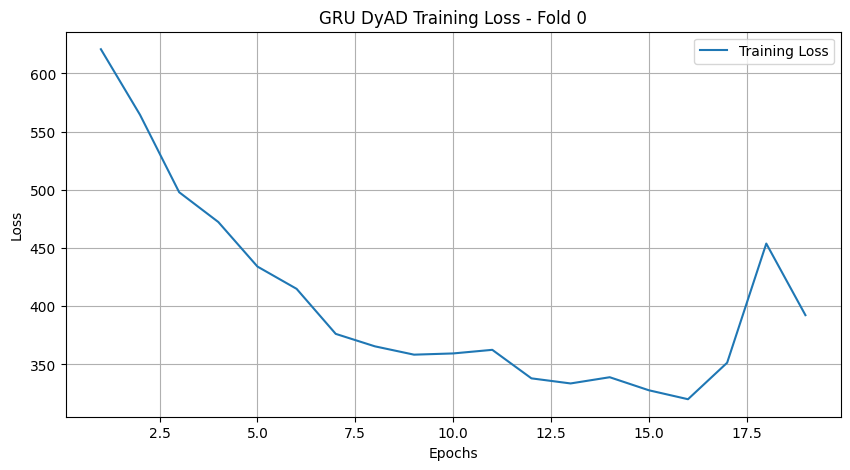

GRU Fold 0 Metrics: AUROC=0.8333, F1=0.9143, RAM=3889MB

Starting GRU fold 1...
Loading normalizer from: /content/drive/My Drive/Projects/EV Batteries/normalizer_fold_1.pkl
GRU Trainable Parameters: 34,501
Epoch 1/75 - Loss: 2.763069 - RAM: 3908MB
Epoch 2/75 - Loss: 2.308790 - RAM: 3908MB
Epoch 3/75 - Loss: 2.381092 - RAM: 3908MB
Epoch 4/75 - Loss: 2.454652 - RAM: 3908MB
Epoch 5/75 - Loss: 2.454797 - RAM: 3908MB
Early stopping triggered
Loading best weights from /content/drive/My Drive/Projects/EV Batteries/temp_gru_best_fold_1.pt
Best GRU model saved to /content/drive/My Drive/Projects/EV Batteries/gru_dyad_fold_1.torch
Temporary checkpoint deleted.


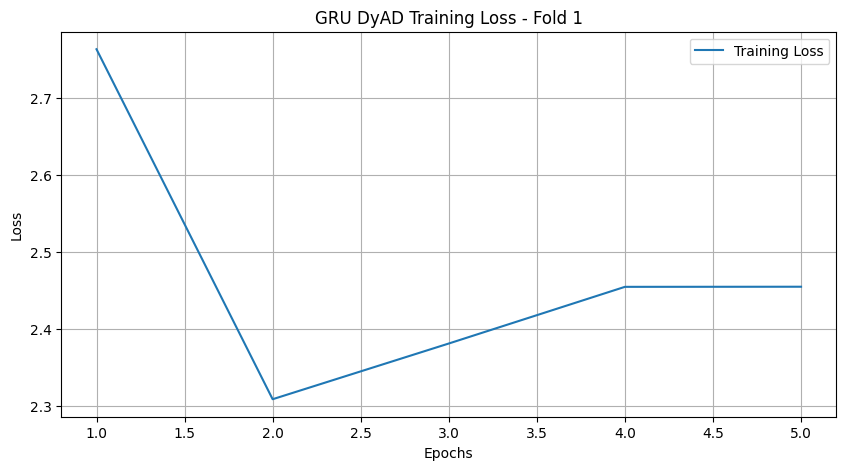

GRU Fold 1 Metrics: AUROC=0.6786, F1=0.8649, RAM=3908MB

Starting GRU fold 2...
Loading normalizer from: /content/drive/My Drive/Projects/EV Batteries/normalizer_fold_2.pkl
GRU Trainable Parameters: 34,501
Epoch 1/75 - Loss: 6.800845 - RAM: 3894MB
Epoch 2/75 - Loss: 5.539854 - RAM: 3894MB
Epoch 3/75 - Loss: 4.909860 - RAM: 3894MB
Epoch 4/75 - Loss: 5.115653 - RAM: 3894MB
Epoch 5/75 - Loss: 4.747983 - RAM: 3894MB
Epoch 6/75 - Loss: 4.899152 - RAM: 3894MB
Epoch 7/75 - Loss: 4.417044 - RAM: 3894MB
Epoch 8/75 - Loss: 4.290458 - RAM: 3894MB
Epoch 9/75 - Loss: 4.155234 - RAM: 3894MB
Epoch 10/75 - Loss: 4.119765 - RAM: 3894MB
Epoch 11/75 - Loss: 4.156744 - RAM: 3894MB
Epoch 12/75 - Loss: 3.989366 - RAM: 3894MB
Epoch 13/75 - Loss: 4.430933 - RAM: 3894MB
Epoch 14/75 - Loss: 3.908960 - RAM: 3894MB
Epoch 15/75 - Loss: 3.885944 - RAM: 3894MB
Epoch 16/75 - Loss: 3.779973 - RAM: 3894MB
Epoch 17/75 - Loss: 3.625970 - RAM: 3894MB
Epoch 18/75 - Loss: 3.549131 - RAM: 3894MB
Epoch 19/75 - Loss: 3.985509 

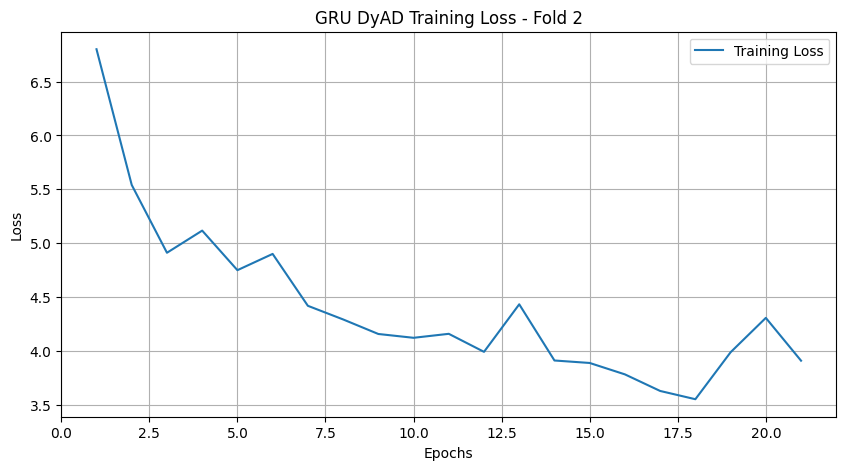

GRU Fold 2 Metrics: AUROC=0.7812, F1=0.9143, RAM=3894MB

Starting GRU fold 3...
Loading normalizer from: /content/drive/My Drive/Projects/EV Batteries/normalizer_fold_3.pkl
GRU Trainable Parameters: 34,501
Epoch 1/75 - Loss: 5.821184 - RAM: 3909MB
Epoch 2/75 - Loss: 4.737000 - RAM: 3909MB
Epoch 3/75 - Loss: 4.367388 - RAM: 3909MB
Epoch 4/75 - Loss: 4.574527 - RAM: 3909MB
Epoch 5/75 - Loss: 4.527018 - RAM: 3909MB
Epoch 6/75 - Loss: 3.835488 - RAM: 3909MB
Epoch 7/75 - Loss: 3.636264 - RAM: 3909MB
Epoch 8/75 - Loss: 3.492812 - RAM: 3909MB
Epoch 9/75 - Loss: 3.417055 - RAM: 3909MB
Epoch 10/75 - Loss: 3.348861 - RAM: 3909MB
Epoch 11/75 - Loss: 3.348187 - RAM: 3909MB
Epoch 12/75 - Loss: 3.310046 - RAM: 3909MB
Epoch 13/75 - Loss: 3.254567 - RAM: 3909MB
Epoch 14/75 - Loss: 3.264115 - RAM: 3909MB
Epoch 15/75 - Loss: 3.266178 - RAM: 3909MB
Epoch 16/75 - Loss: 3.198230 - RAM: 3909MB
Epoch 17/75 - Loss: 3.221659 - RAM: 3909MB
Epoch 18/75 - Loss: 3.185706 - RAM: 3909MB
Epoch 19/75 - Loss: 4.044176 

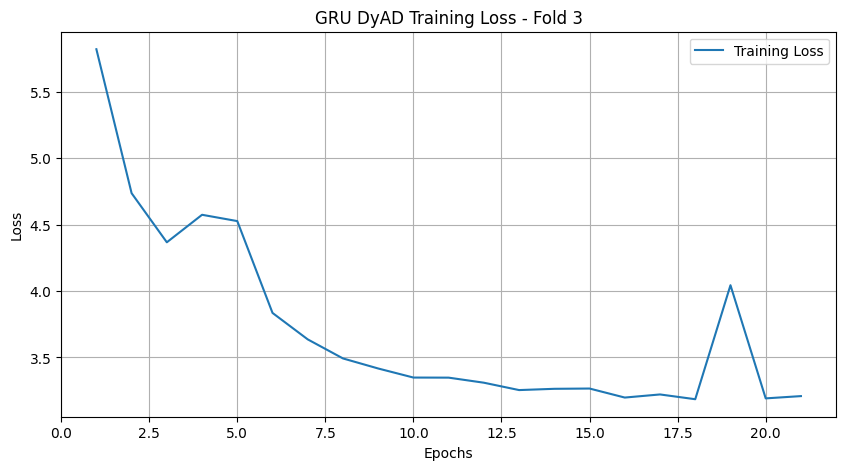

GRU Fold 3 Metrics: AUROC=0.8125, F1=0.8649, RAM=3909MB

Starting GRU fold 4...
Loading normalizer from: /content/drive/My Drive/Projects/EV Batteries/normalizer_fold_4.pkl
GRU Trainable Parameters: 34,501
Epoch 1/75 - Loss: 6.035954 - RAM: 3906MB
Epoch 2/75 - Loss: 5.030408 - RAM: 3906MB
Epoch 3/75 - Loss: 4.823605 - RAM: 3906MB
Epoch 4/75 - Loss: 5.060600 - RAM: 3906MB
Epoch 5/75 - Loss: 4.460358 - RAM: 3906MB
Epoch 6/75 - Loss: 4.133401 - RAM: 3906MB
Epoch 7/75 - Loss: 3.954724 - RAM: 3906MB
Epoch 8/75 - Loss: 4.220885 - RAM: 3906MB
Epoch 9/75 - Loss: 3.837482 - RAM: 3906MB
Epoch 10/75 - Loss: 3.623750 - RAM: 3906MB
Epoch 11/75 - Loss: 3.594764 - RAM: 3906MB
Epoch 12/75 - Loss: 3.577131 - RAM: 3906MB
Epoch 13/75 - Loss: 3.490237 - RAM: 3906MB
Epoch 14/75 - Loss: 3.410313 - RAM: 3906MB
Epoch 15/75 - Loss: 3.369283 - RAM: 3906MB
Epoch 16/75 - Loss: 3.310070 - RAM: 3906MB
Epoch 17/75 - Loss: 3.324936 - RAM: 3906MB
Epoch 18/75 - Loss: 3.470125 - RAM: 3906MB
Epoch 19/75 - Loss: 3.322008 

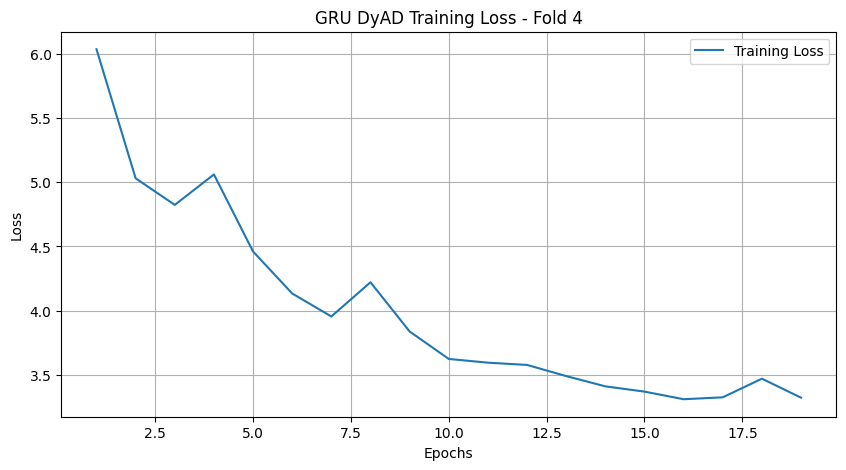

GRU Fold 4 Metrics: AUROC=0.9464, F1=0.9412, RAM=3906MB


In [ ]:
#running the training and displaying the results (huber loss inference)
random.seed(777)
gru_fold_results = []

for i in range(5):
    metrics = run_fold_gru(fold_num=i)
    gru_fold_results.append(metrics)

In [ ]:
print('FINAL GRU RESULTS (5-Fold)')

metric_keys = gru_fold_results[0].keys()
gru_final_stats = {}

for key in metric_keys:
    values = [res[key] for res in gru_fold_results]
    mean_val = np.mean(values)
    std_val = np.std(values)
    cv_val = (std_val / mean_val) if mean_val != 0 else 0.0
    gru_final_stats[key] = (mean_val, std_val, cv_val)

    print(f'Metric: {key.upper()}')
    print(f'  Values: {[f'{v:.4f}' for v in values]}')
    print(f'  Result: {mean_val:.4f} \u00b1 {std_val:.4f}')
    if key in CV_METRICS:
        cv_val = (std_val / mean_val) if mean_val != 0 else 0.0
        print(f'  CV:     {cv_val:.2%}')

FINAL GRU RESULTS (5-Fold)
Metric: AUROC
  Values: ['0.8333', '0.6786', '0.7812', '0.8125', '0.9464']
  Result: 0.8104 ± 0.0863
Metric: AUPRC
  Values: ['0.9314', '0.8012', '0.9070', '0.9175', '0.9757']
  Result: 0.9066 ± 0.0576
Metric: F1
  Values: ['0.9143', '0.8649', '0.9143', '0.8649', '0.9412']
  Result: 0.8999 ± 0.0302
Metric: PRECISION
  Values: ['0.8421', '0.7619', '0.8421', '0.7619', '0.8889']
  Result: 0.8194 ± 0.0499
Metric: RECALL
  Values: ['1.0000', '1.0000', '1.0000', '1.0000', '1.0000']
  Result: 1.0000 ± 0.0000
Metric: OPTIMAL_THRESHOLD
  Values: ['1.3412', '0.4338', '0.7795', '0.8041', '0.9131']
  Result: 0.8543 ± 0.2917
  CV:     34.15%
Metric: TRAIN_TIME
  Values: ['254.2760', '71.5124', '287.6990', '356.7185', '299.0727']
  Result: 253.8557 ± 96.9742
  CV:     38.20%
Metric: TEST_TIME
  Values: ['18.9865', '18.8240', '18.7831', '16.6420', '17.3633']
  Result: 18.1198 ± 0.9427
  CV:     5.20%
Metric: MAX_RAM_MB
  Values: ['3889.1055', '3907.6133', '3893.8555', '3909


Starting GRU fold 0...
Loading normalizer from: /content/drive/My Drive/Projects/EV Batteries/normalizer_fold_0.pkl
GRU Trainable Parameters: 34,501
Epoch 1/75 - Loss: 602.847801 - RAM: 3909MB
Epoch 2/75 - Loss: 519.352354 - RAM: 3909MB
Epoch 3/75 - Loss: 473.465007 - RAM: 3909MB
Epoch 4/75 - Loss: 439.676163 - RAM: 3909MB
Epoch 5/75 - Loss: 389.767199 - RAM: 3909MB
Epoch 6/75 - Loss: 349.220373 - RAM: 3909MB
Epoch 7/75 - Loss: 323.896267 - RAM: 3909MB
Epoch 8/75 - Loss: 337.573870 - RAM: 3909MB
Epoch 9/75 - Loss: 491.831911 - RAM: 3909MB
Epoch 10/75 - Loss: 416.191284 - RAM: 3909MB
Early stopping triggered
Loading best weights from /content/drive/My Drive/Projects/EV Batteries/temp_gru_best_fold_0.pt
Best GRU model saved to /content/drive/My Drive/Projects/EV Batteries/gru_dyad_fold_0.torch
Temporary checkpoint deleted.


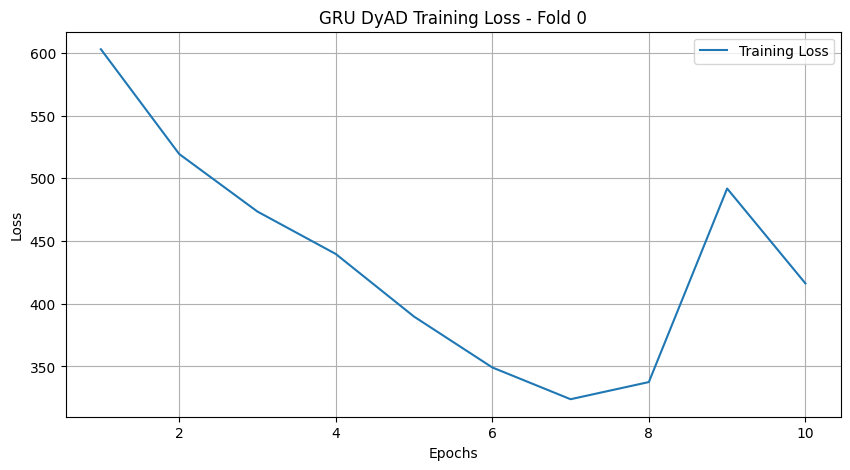

GRU Fold 0 Metrics: AUROC=0.9062, F1=0.9375, RAM=3909MB

Starting GRU fold 1...
Loading normalizer from: /content/drive/My Drive/Projects/EV Batteries/normalizer_fold_1.pkl
GRU Trainable Parameters: 34,501
Epoch 1/75 - Loss: 2.770200 - RAM: 3912MB
Epoch 2/75 - Loss: 2.231030 - RAM: 3912MB
Epoch 3/75 - Loss: 2.305758 - RAM: 3912MB
Epoch 4/75 - Loss: 2.391621 - RAM: 3912MB
Epoch 5/75 - Loss: 2.348884 - RAM: 3912MB
Early stopping triggered
Loading best weights from /content/drive/My Drive/Projects/EV Batteries/temp_gru_best_fold_1.pt
Best GRU model saved to /content/drive/My Drive/Projects/EV Batteries/gru_dyad_fold_1.torch
Temporary checkpoint deleted.


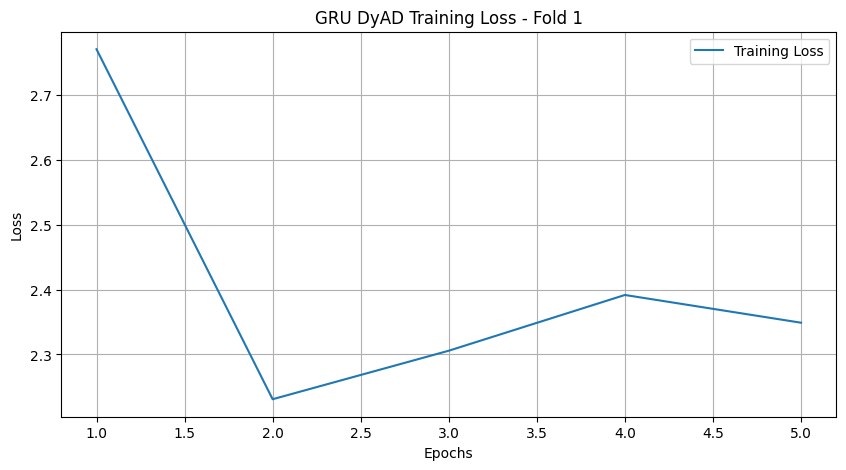

GRU Fold 1 Metrics: AUROC=0.7143, F1=0.8889, RAM=3912MB

Starting GRU fold 2...
Loading normalizer from: /content/drive/My Drive/Projects/EV Batteries/normalizer_fold_2.pkl
GRU Trainable Parameters: 34,501
Epoch 1/75 - Loss: 6.793935 - RAM: 3911MB
Epoch 2/75 - Loss: 5.505978 - RAM: 3911MB
Epoch 3/75 - Loss: 5.092716 - RAM: 3911MB
Epoch 4/75 - Loss: 4.724796 - RAM: 3911MB
Epoch 5/75 - Loss: 4.585102 - RAM: 3911MB
Epoch 6/75 - Loss: 4.641401 - RAM: 3911MB
Epoch 7/75 - Loss: 4.333378 - RAM: 3911MB
Epoch 8/75 - Loss: 4.181751 - RAM: 3911MB
Epoch 9/75 - Loss: 5.066712 - RAM: 3911MB
Epoch 10/75 - Loss: 4.513160 - RAM: 3911MB
Epoch 11/75 - Loss: 4.109196 - RAM: 3911MB
Epoch 12/75 - Loss: 4.150358 - RAM: 3911MB
Epoch 13/75 - Loss: 4.228505 - RAM: 3911MB
Epoch 14/75 - Loss: 3.997762 - RAM: 3911MB
Epoch 15/75 - Loss: 4.252537 - RAM: 3911MB
Epoch 16/75 - Loss: 3.983634 - RAM: 3911MB
Epoch 17/75 - Loss: 3.960566 - RAM: 3911MB
Epoch 18/75 - Loss: 3.853052 - RAM: 3911MB
Epoch 19/75 - Loss: 3.756772 

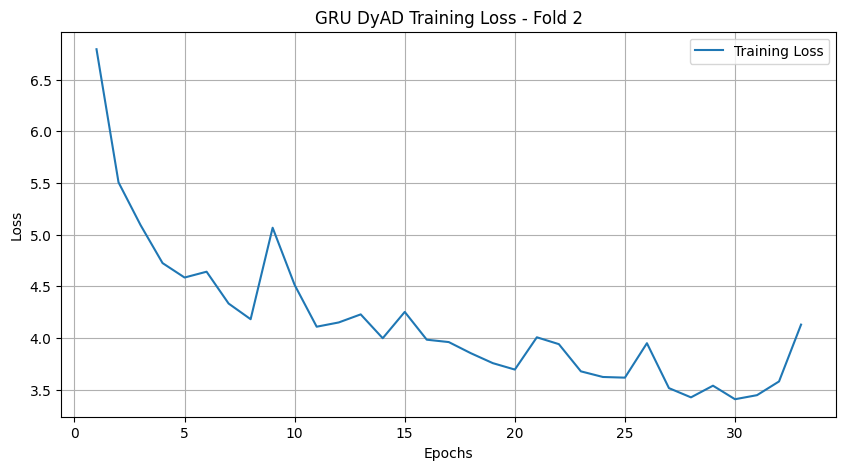

GRU Fold 2 Metrics: AUROC=0.8021, F1=0.9412, RAM=3911MB

Starting GRU fold 3...
Loading normalizer from: /content/drive/My Drive/Projects/EV Batteries/normalizer_fold_3.pkl
GRU Trainable Parameters: 34,501
Epoch 1/75 - Loss: 5.966469 - RAM: 3910MB
Epoch 2/75 - Loss: 4.798265 - RAM: 3910MB
Epoch 3/75 - Loss: 4.457567 - RAM: 3910MB
Epoch 4/75 - Loss: 4.288136 - RAM: 3910MB
Epoch 5/75 - Loss: 3.919436 - RAM: 3910MB
Epoch 6/75 - Loss: 3.673822 - RAM: 3910MB
Epoch 7/75 - Loss: 3.755026 - RAM: 3910MB
Epoch 8/75 - Loss: 3.536953 - RAM: 3910MB
Epoch 9/75 - Loss: 3.469661 - RAM: 3910MB
Epoch 10/75 - Loss: 3.391394 - RAM: 3910MB
Epoch 11/75 - Loss: 3.387451 - RAM: 3910MB
Epoch 12/75 - Loss: 3.360564 - RAM: 3910MB
Epoch 13/75 - Loss: 3.336744 - RAM: 3910MB
Epoch 14/75 - Loss: 3.661361 - RAM: 3910MB
Epoch 15/75 - Loss: 3.413071 - RAM: 3910MB
Epoch 16/75 - Loss: 3.265036 - RAM: 3910MB
Epoch 17/75 - Loss: 3.199767 - RAM: 3910MB
Epoch 18/75 - Loss: 3.227719 - RAM: 3910MB
Epoch 19/75 - Loss: 3.754654 

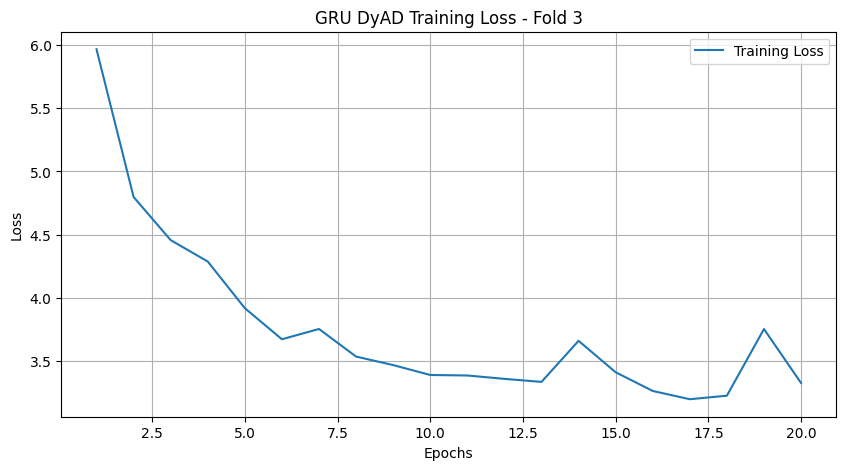

GRU Fold 3 Metrics: AUROC=0.7589, F1=0.8649, RAM=3910MB

Starting GRU fold 4...
Loading normalizer from: /content/drive/My Drive/Projects/EV Batteries/normalizer_fold_4.pkl
GRU Trainable Parameters: 34,501
Epoch 1/75 - Loss: 6.184578 - RAM: 3911MB
Epoch 2/75 - Loss: 5.166109 - RAM: 3911MB
Epoch 3/75 - Loss: 4.811363 - RAM: 3911MB
Epoch 4/75 - Loss: 4.439311 - RAM: 3911MB
Epoch 5/75 - Loss: 4.205923 - RAM: 3911MB
Epoch 6/75 - Loss: 4.083488 - RAM: 3911MB
Epoch 7/75 - Loss: 4.257812 - RAM: 3911MB
Epoch 8/75 - Loss: 4.208145 - RAM: 3911MB
Epoch 9/75 - Loss: 4.087551 - RAM: 3911MB
Early stopping triggered
Loading best weights from /content/drive/My Drive/Projects/EV Batteries/temp_gru_best_fold_4.pt
Best GRU model saved to /content/drive/My Drive/Projects/EV Batteries/gru_dyad_fold_4.torch
Temporary checkpoint deleted.


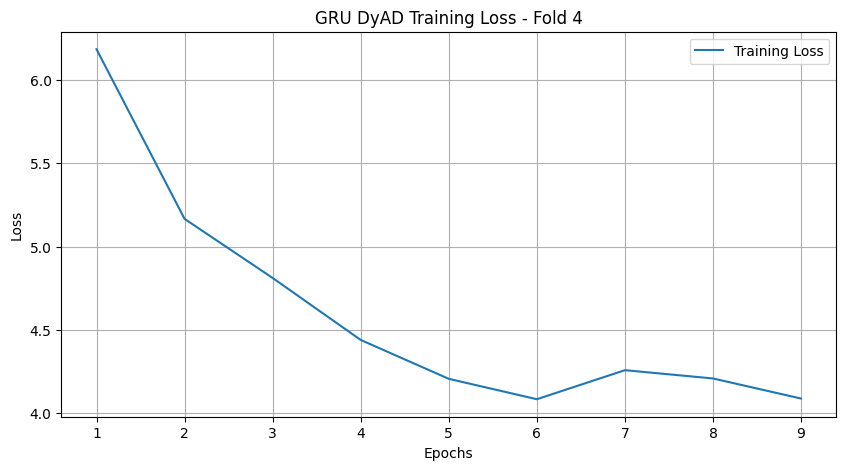

GRU Fold 4 Metrics: AUROC=0.7232, F1=0.8421, RAM=3911MB


In [ ]:
#running the training and displaying the results (mse inference)
random.seed(777)
gru_fold_results_mse = []

for i in range(5):
    metrics = run_fold_gru(fold_num=i, inference_loss_type='mse')
    gru_fold_results_mse.append(metrics)

In [ ]:
print(f'FINAL GRU RESULTS MSE (5-Fold)')

metric_keys = gru_fold_results_mse[0].keys()
gru_final_stats_mse = {}

for key in metric_keys:
    values = [res[key] for res in gru_fold_results_mse]
    mean_val = np.mean(values)
    std_val = np.std(values)
    cv_val = (std_val / mean_val) if mean_val != 0 else 0.0
    gru_final_stats_mse[key] = (mean_val, std_val, cv_val)

    print(f'Metric: {key.upper()}')
    print(f'  Values: {[f'{v:.4f}' for v in values]}')
    print(f'  Result: {mean_val:.4f} ± {std_val:.4f}')
    if key in CV_METRICS:
        cv_val = (std_val / mean_val) if mean_val != 0 else 0.0
        print(f'  CV:     {cv_val:.2%}')

FINAL GRU RESULTS MSE (5-Fold)
Metric: AUROC
  Values: ['0.9062', '0.7143', '0.8021', '0.7589', '0.7232']
  Result: 0.7810 ± 0.0699
Metric: AUPRC
  Values: ['0.9649', '0.8428', '0.9055', '0.9032', '0.8922']
  Result: 0.9017 ± 0.0389
Metric: F1
  Values: ['0.9375', '0.8889', '0.9412', '0.8649', '0.8421']
  Result: 0.8949 ± 0.0392
Metric: PRECISION
  Values: ['0.9375', '0.8000', '0.8889', '0.7619', '0.7273']
  Result: 0.8231 ± 0.0786
Metric: RECALL
  Values: ['0.9375', '1.0000', '1.0000', '1.0000', '1.0000']
  Result: 0.9875 ± 0.0250
Metric: OPTIMAL_THRESHOLD
  Values: ['8.9506', '0.5936', '2.9140', '2.9282', '2.2300']
  Result: 3.5233 ± 2.8438
  CV:     80.72%
Metric: TRAIN_TIME
  Values: ['132.6433', '71.1251', '452.3166', '337.8509', '141.0320']
  Result: 226.9936 ± 143.9765
  CV:     63.43%
Metric: TEST_TIME
  Values: ['18.9069', '18.3851', '19.1958', '16.5976', '17.3658']
  Result: 18.0903 ± 0.9725
  CV:     5.38%
Metric: MAX_RAM_MB
  Values: ['3908.5430', '3911.8828', '3911.1523', 